In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import  DataLoader, Subset
import torch.nn.init as init
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import random
import gc
import os
import importlib.util

from utils.ESPF_drug2emb import drug2emb_encoder
from utils.Model import Omics_DrugESPF_Model, Omics_DCSA_Model
from utils.split_data_id import split_id,repeat_func
from utils.create_dataloader import OmicsDrugDataset
from utils.train import train, evaluation
from utils.correlation import correlation_func
from utils.plot import loss_curve, correlation_density,Density_Plot_of_AUC_Values
from utils.tools import get_data_value_range,set_seed,get_vram_usage

device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [ ]:
import pickle
with open("../data/DAPL/share/pretrain/VAE/ccle_latent_results.pkl", 'rb') as f:
    latent_dict = pickle.load(f)

In [8]:
df = pd.DataFrame(latent_dict).T
print(df)

                  0         1         2         3         4             5   \
ACH-000001  0.000017 -0.000060 -0.000004  0.000005 -0.000007  6.381051e-06   
ACH-000002  0.000014  0.000037 -0.000006  0.000007 -0.000008 -6.002442e-07   
ACH-000003  0.000014 -0.000028 -0.000008  0.000006  0.000003  3.770715e-06   
ACH-000004  0.331396 -0.182001 -0.056711  0.269614 -0.071013  5.813973e-02   
ACH-000005  0.347627  0.488505 -0.245182  0.087534 -0.218954 -7.688981e-02   
...              ...       ...       ...       ...       ...           ...   
ACH-002045 -0.000033 -0.000004 -0.000008  0.000007 -0.000015  2.064383e-06   
ACH-002059 -0.000010 -0.000042 -0.000007  0.000007 -0.000015  5.848758e-06   
ACH-002066  0.000008 -0.000073 -0.000006  0.000006 -0.000013  6.132440e-06   
ACH-002446  0.000003  0.000076 -0.000006  0.000007 -0.000004  2.252690e-06   
ACH-002509 -0.000027 -0.000033 -0.000007  0.000003 -0.000006  1.018298e-05   

                  6         7         8         9   ...        

In [9]:
df.shape

(1305, 32)

In [27]:
# pip install subword-nmt seaborn lifelines openpyxl matplotlib scikit-learn openTSNE
# pip uninstall torchmetrics pandas numpy -y
# pip install torchmetrics==1.2.0 pandas==2.1.4 numpy==1.26.4
# python3 ./main_kfold.py --config utils/config.py
import torch.nn as nn
from utils.Loss import Custom_LossFunction,Custom_Weighted_LossFunction,FocalLoss
from utils.Custom_Activation_Function import ScaledSigmoid, ReLU_clamp
from utils.Metrics import MetricsCalculator_nntorch

test = False #False, True: batch_size = 3, num_epoch = 2, full dataset

omics_files = {
    'Mut': "../data/CCLE/CCLE_match_TCGAgene_PRISMandEXPsample_binary_mutation_476_6009.txt",
    'Exp': "../data/CCLE/CCLE_exp_476samples_4692genes.txt",
    # Add more omics types and paths as needed
    }
omics_dict = {'Mut':0,'Exp':1,'CN':2, 'Eff':3, 'Dep':4, 'Met':5}
omics_data_dict = {}
omics_data_tensor_dict = {}
omics_numfeatures_dict = {}
omics_encode_dim_dict ={'Mut':[1000,100,50],'Exp':[1000,100,50], # Dr.Chiu:exp[500,200,50]
                        'CN':[100,50,30], 'Eff':[100,50,30], 'Dep':[100,50,30], 'Met':[100,50,30]}

TCGA_pretrain_weight_path_dict = {'Mut': "./results/Encoder_tcga_mut_1000_100_50_best_loss_0.0066.pt",
                                  'Exp': "./results/Encoder_tcga_exp_1000_100_50_best_loss_0.7.pt",
                                  # Add more omics types and paths as needed
                                }
seed = 42
#hyperparameter
model_name = "Omics_DCSA_Model" # Omics_DrugESPF_Model  Omics_DCSA_Model
AUCtransform = None #"-log2"
splitType= 'byCCL' # byCCL byDrug
kfoldCV = 2
include_omics = ['Mut', 'Exp']
max_drug_len=50 # 不夠補零補到50 / 超過取前50個subwords(index) !!!!須改方法!!!! 
drug_embedding_feature_size = 128
ESPF = True # False True
Drug_SelfAttention = True
n_layer = 3
pos_emb_type = 'sinusoidal' # 'learned' 'sinusoidal'
#需再修改-----------

intermediate_size =512
num_attention_heads = 8        
attention_probs_dropout_prob = 0.1
hidden_dropout_prob = 0.1

if ESPF is True:
    drug_encode_dims =[1600,400,100] # 50*128  
    dense_layer_dim = sum(omics_encode_dim_dict[omic_type][2] for omic_type in include_omics) + drug_encode_dims[2] # MLPDim
elif ESPF is False:
    drug_encode_dims =[110,55,22]
    dense_layer_dim = sum(omics_encode_dim_dict[omic_type][2] for omic_type in include_omics) + drug_encode_dims[2] # MLPDim
if model_name == "Omics_DCSA_Model":
    drug_encode_dims =[(max_drug_len+len(include_omics))*(drug_embedding_feature_size+num_attention_heads)+ (len(include_omics)*128), 700, 70, 1] #
    dense_layer_dim = None
print("drug_encode_dims",drug_encode_dims)
print("dense_layer_dim",dense_layer_dim)
#需再修改-------------
TrackGradient = False # False True

activation_func = nn.ReLU()  # ReLU activation function # Leaky ReLu
activation_func_final = nn.Sigmoid() # ScaledSigmoid(scale=8) GroundT range ( 0 ~ scale ) # ReLU_clamp(max=8)
#nn.Sigmoid()or ReLU() or Linear/identity(when -log2AUC)
batch_size = 500
num_epoch = 200 # for k fold CV 
patience = 20
warmup_iters = 60
Decrease_percent = 1
continuous = True
learning_rate=1e-04
metrics_type_set = [ "MSE", "R^2"] # "MSE", MAE"
metrics_calculator = MetricsCalculator_nntorch(types = metrics_type_set)
criterion = Custom_LossFunction(loss_type="MAE", loss_lambda=1.0, regular_type=None, regular_lambda=1e-06) #nn.MSELoss()#
#criterion =  FocalMSELoss(alpha=8.0, gamma=1.0, regular_type=None, regular_lambda=1e-05)
""" A customizable loss function class.
    Args:
        loss_type (str): The type of loss to use ("RMSE", "MSE", "MAE", "MAE+MSE", "MAE+RMSE")/("weighted_RMSE", "weighted_MSE", "weighted_MAE", "weighted_MAE+MSE", "weighted_MAE+RMSE").
        loss_lambda (float): The lambda weight for the additional loss (MSE or RMSE) if applicable. Default is MAE+ 1.0*(MSE or RMSE).
        regular_type (str): The type of regularization to use ("L1", "L2", "L1+L2"), or None for no regularization.
        regular_lambda (float): The lambda weight for regularization. Default is 1e-05."""

hyperparameter_print = f' omics_dict ={omics_dict}\n omics_files ={omics_files}\n TCGA_pretrain_weight_path_dict ={TCGA_pretrain_weight_path_dict}\n seed ={seed}\n  model_name ={model_name}\n AUCtransform ={AUCtransform}\n splitType ={splitType}\n kfoldCV ={kfoldCV}\n omics_encode_dim ={[(omic_type,omics_encode_dim_dict[omic_type]) for omic_type in include_omics]}\n max_drug_len ={max_drug_len}\n drug_embedding_feature_size ={drug_embedding_feature_size}\n ESPF ={ESPF}\n Drug_SelfAttention ={Drug_SelfAttention}\n n_layer ={n_layer}\n pos_emb_type ={pos_emb_type}\n intermediate_size ={intermediate_size}\n num_attention_heads ={num_attention_heads}\n attention_probs_dropout_prob ={attention_probs_dropout_prob}\n hidden_dropout_prob ={hidden_dropout_prob}\n drug_encode_dims ={drug_encode_dims}\n dense_layer_dim = {dense_layer_dim}\n activation_func = {activation_func}\n activation_func_final = {activation_func_final}\n batch_size = {batch_size}\n num_epoch = {num_epoch}\n patience = {patience}\n warmup_iters = {warmup_iters}\n Decrease_percent = {Decrease_percent}\n continuous ={continuous}\n learning_rate = {learning_rate}\n criterion ={criterion}\n'

__translation_table__ = str.maketrans({
    "*": "",    "/": "",    ":": "-",    "%": "",
    "'": "",    "\"": "",    "[": "",    "]": "",
    ",": "" })

hyperparameter_folder_part = (f'Model{model_name}_{splitType}_Omics{[omic_type for omic_type in include_omics]}_ESPF{ESPF}_DrugSelfAttention{Drug_SelfAttention}').translate(__translation_table__)



drug_encode_dims [7328, 700, 70, 1]
dense_layer_dim None


In [3]:
set_seed(seed)
for omic_type in include_omics:
    # Read the file
    omics_data_dict[omic_type] = pd.read_csv(omics_files[omic_type], sep='\t', index_col=0)

    if test is True:
        # Specify the index as needed
        omics_data_dict[omic_type] = omics_data_dict[omic_type][:76]  # Adjust the row selection as needed  
    if omic_type == "Exp":# apply Column-wise Min-Max Normalization 
        scaler = StandardScaler() 
        omics_data_dict[omic_type] = pd.DataFrame(scaler.fit_transform(omics_data_dict[omic_type]),index=omics_data_dict[omic_type].index,columns=omics_data_dict[omic_type].columns)

    omics_data_tensor_dict[omic_type]  = torch.tensor(omics_data_dict[omic_type].values, dtype=torch.float32).to(device)
    omics_numfeatures_dict[omic_type] = omics_data_tensor_dict[omic_type].shape[1]
 
    print(f"{omic_type} tensor shape:", omics_data_tensor_dict[omic_type].shape)
    print(f"{omic_type} num_features",omics_numfeatures_dict[omic_type])

Mut tensor shape: torch.Size([476, 6009])
Mut num_features 6009
Exp tensor shape: torch.Size([476, 4692])
Exp num_features 4692


In [4]:
drug_df = pd.read_csv( "../data/no_Imputation_PRISM_Repurposing_Secondary_Screen_data/MACCS(Secondary_Screen_treatment_info)_union_NOrepeat.csv", sep=',', index_col=0)
AUC_df = pd.read_csv( "../data/no_Imputation_PRISM_Repurposing_Secondary_Screen_data/Drug_sensitivity_AUC_(PRISM_Repurposing_Secondary_Screen)_subsetted_NOrepeat.csv", sep=',', index_col=0)
matched_samples = sorted(set(AUC_df.T.columns) & set(list(omics_data_dict.values())[0].T.columns))
AUC_df= (AUC_df.T[matched_samples]).T
print("AUC_df",AUC_df.shape)
if AUCtransform == "-log2":
    AUC_df = -np.log2(AUC_df)
if AUCtransform == "-log10":
    AUC_df = -np.log10(AUC_df)
print("drug_df",drug_df.shape)
print("AUC_df",AUC_df.shape)

if test is True:
    batch_size = 3
    num_epoch = 2
    print("batch_size",batch_size,"num_epoch:",num_epoch)
    drug_df=drug_df[:42]
    AUC_df=AUC_df.iloc[:76,:42]
    print("drug_df",drug_df.shape)
    print("AUC_df",AUC_df.shape)
    kfoldCV = 2
    print("kfoldCV",kfoldCV)

if 'weighted' in criterion.loss_type :    
    weighted_threshold = np.nanpercentile(AUC_df.values, 90)    
    total_samples = (~np.isnan(AUC_df.values)).sum().item()
    fewWt_samples = (AUC_df.values > weighted_threshold).sum().item()
    moreWt_samples = total_samples - fewWt_samples
    few_weight = total_samples / (2 * fewWt_samples)  
    more_weight = total_samples / (2 * moreWt_samples)   
else:
    weighted_threshold = None
    few_weight = None
    more_weight = None
print("weighted_threshold:",weighted_threshold)

AUC_df (476, 1440)
drug_df (1440, 9)
AUC_df (476, 1440)
weighted_threshold: None


In [5]:
if ESPF is True:
    drug_smiles =drug_df["smiles"] # 
    drug_names =drug_df.index
    # 挑出重複的SMILES
    duplicate =  drug_smiles[drug_smiles.duplicated(keep=False)]
    vocab_path = "./ESPF/drug_codes_chembl_freq_1500.txt" # token
    sub_csv = pd.read_csv("./ESPF/subword_units_map_chembl_freq_1500.csv")# token with frequency
    drug_encode = pd.Series(drug_smiles).apply(drug2emb_encoder, args=(vocab_path, sub_csv, max_drug_len))
    drug_features_tensor = torch.tensor(np.array([i[:2] for i in drug_encode.values]), dtype=torch.long).to(device)#drug_features_tensor = torch.tensor(np.array(drug_encode.values.tolist()), dtype=torch.long).to(device)
else:
    drug_encode = drug_df["MACCS166bits"]
    drug_encode_list = [list(map(int, item.split(','))) for item in drug_encode.values]
    print("MACCS166bits_drug_encode_list type: ",type(drug_encode_list))
    drug_features_tensor = torch.tensor(np.array(drug_encode_list), dtype=torch.long).to(device)
#--------------------------------------------------------------------------------------------------------------------------
num_ccl = list(omics_data_dict.values())[0].shape[0]
num_drug = drug_encode.shape[0]
print("num_ccl,num_drug: ",num_ccl,num_drug)

# Convert your data to tensors if they're in numpy
response_matrix_tensor = torch.tensor(AUC_df.values, dtype=torch.float32).to(device)
print(response_matrix_tensor.shape)
print(drug_encode.values[0][2])

num_ccl,num_drug:  476 1440
torch.Size([476, 1440])
['Nc1nc(', 'O)', 'c2nc(', 'Br)', 'n(', '[C@@H]3', 'O[C@@H]4', 'CO', 'P', '(O)', '(=O)', 'O[C@H]4', '[C@H]3', 'O)c2', 'n1']


In [6]:
id_unrepeat_test, id_unrepeat_train_val = split_id(num_ccl,num_drug,splitType,kfoldCV,repeat=True)
# repeat the test id
if splitType == "byCCL":
    repeatNum = num_drug
elif splitType == "byDrug":
    repeatNum = num_ccl
id_test = repeat_func(id_unrepeat_test, repeatNum, setname='test')


id_unrepeat_train (380,)
id_unrepeat_val (48,)
id_unrepeat_test (48,)
id_unrepeat_train_val (428,)
id_test.shape (69120,)


In [7]:
print(id_test[:10])

[10080 10081 10082 10083 10084 10085 10086 10087 10088 10089]


In [8]:
set_seed(seed)
dataset = OmicsDrugDataset(omics_data_tensor_dict, drug_features_tensor, response_matrix_tensor, splitType, include_omics)

test_dataset = Subset(dataset, id_test.tolist())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # , num_workers=4, pin_memory=True
#create whole dataset
whole_loader = DataLoader(dataset, batch_size=6000, shuffle=False) # 685440


self.num_drugs 1440


In [9]:
%%time
# inference

if model_name == "Omics_DrugESPF_Model":
    model = Omics_DrugESPF_Model(omics_encode_dim_dict, drug_encode_dims, activation_func, activation_func_final, dense_layer_dim, device, ESPF, Drug_SelfAttention, pos_emb_type,
                        drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,
                        n_layer,TCGA_pretrain_weight_path_dict= TCGA_pretrain_weight_path_dict)
elif model_name == "Omics_DCSA_Model":
    model = Omics_DCSA_Model(omics_encode_dim_dict, drug_encode_dims, activation_func, activation_func_final, dense_layer_dim, device, ESPF, Drug_SelfAttention, pos_emb_type,
                        drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,
                        n_layer,TCGA_pretrain_weight_path_dict= TCGA_pretrain_weight_path_dict)
model.to(device=device)
best_weight_path = './inference/BF3_test_loss0.0565073_BestValEpo15_ModelOmics_DCSA_Model_byCCL_OmicsMut_Exp_ESPFTrue_DrugSelfAttentionTrue/'
best_weight = best_weight_path + "BestValWeight.pt"

model.load_state_dict(torch.load(best_weight))

# eval_targets, eval_outputs,predAUCwithUnknownGT, AttenScorMat_DrugSelf, AttenScorMat_DrugCellSelf,eval_outputs_before_final_activation_list, mean_batch_eval_lossWOpenalty
(eval_targets, eval_outputs,predAUCwithUnknownGT,
 _ ,_,
 eval_outputs_before_final_activation_list, 
 mean_batch_eval_lossWOpenalty)  = evaluation(model, None,None,
                                             criterion, whole_loader, device,ESPF,Drug_SelfAttention, 
                                             weighted_threshold, few_weight, more_weight, 
                                             outputcontrol='inference')



State_dict for Sequential(
  (0): Linear(in_features=6009, out_features=1000, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1000, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=50, bias=True)
) loaded successfully.
State_dict for Sequential(
  (0): Linear(in_features=4692, out_features=1000, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1000, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=50, bias=True)
) loaded successfully.

 Drug_SelfAttention is applied 

CPU times: user 55.9 s, sys: 385 ms, total: 56.3 s
Wall time: 59.5 s


In [10]:
predAUCwithUnknownGT_list = np.concatenate(predAUCwithUnknownGT)
print(predAUCwithUnknownGT_list.shape)
predAUCmatrix = predAUCwithUnknownGT_list.reshape(476, 1440) # numpy.ndarray

predAUCmatrix_df = pd.DataFrame(predAUCmatrix, columns=AUC_df.columns, index=AUC_df.index)
# Output to CSV
predAUCmatrix_df.to_csv(best_weight_path+'predicted AUC values with UnknownGroundTruth samples.csv')
print("CSV file has been saved.")

(685440,)
CSV file has been saved.


In [11]:
print("eval_targets\n",eval_targets[0][:10])
print("eval_outputs_before_final_activation_list\n",eval_outputs_before_final_activation_list[0][:10])
print("eval_outputs\n",eval_outputs[0][:10])

eval_targets
 tensor([0.9036, 0.9385, 0.5121, 0.8205, 0.8813, 0.7088, 0.7894, 0.7654, 0.8884,
        0.7771], device='cuda:0')
eval_outputs_before_final_activation_list
 [2.1159794  2.0993063  0.03536889 1.4783438  2.0645936  1.3546202
 1.1664014  1.5703093  2.5710943  1.7056267 ]
eval_outputs
 tensor([0.8924, 0.8908, 0.5088, 0.8143, 0.8874, 0.7949, 0.7625, 0.8278, 0.9290,
        0.8463], device='cuda:0')


In [15]:
mean_batch_eval_lossWOpenalty

array(0.05497103, dtype=float32)

In [ ]:
metrics_calculator = MetricsCalculator_nntorch()
eval_metrics= metrics_calculator(torch.cat(eval_targets), torch.cat(eval_outputs),median_value=None)
print(eval_metrics)

{'MSE': tensor(0.0059, device='cuda:0'), 'MAE': tensor(0.0550, device='cuda:0'), 'R^2': tensor(0.7708, device='cuda:0')}


In [18]:
if splitType == "byCCL":
    id_unrepeat_whole = list(range(476))
elif splitType == "byDrug":
    id_unrepeat_whole = list(range(1440))
    id_unrepeat_whole[:10], id_unrepeat_whole[-10:]  # Display the first and last 10 elements to confirm

eval_pearson, eval_spearman,eval_AllSameValuesList_count  = correlation_func(splitType, AUC_df.values,AUC_df.index,AUC_df.columns,id_unrepeat_whole,torch.cat(eval_targets),torch.cat(eval_outputs))

Text(0.5, 0.98, 'Density Plot of Correlation Omics_DrugESPF_Model')

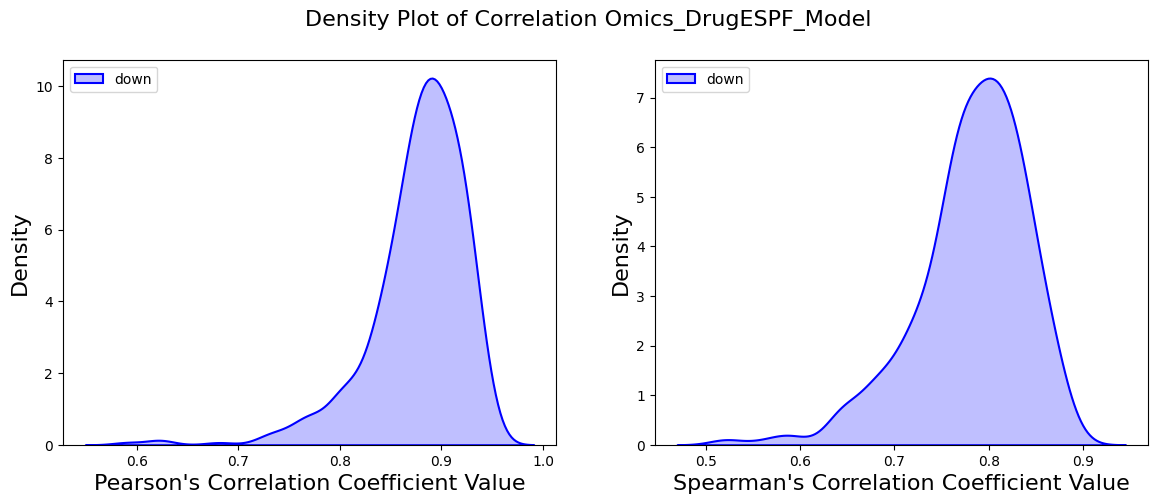

In [19]:
#pearson
# Create a density plot using seaborn's kdeplot function
fig=plt.figure(figsize=(14, 5))
# Set the title of the plot

plt.subplot(1,2,1)
# sns.kdeplot(test_pearson1, fill=True, color='red', label='up',linewidth=1.5)
sns.kdeplot(eval_pearson, fill=True, color='blue', label='down',linewidth=1.5)
# Set the x-axis label to 'Density'
plt.xlabel('Pearson\'s Correlation Coefficient Value', fontsize=16)
# Set the y-axis label to 'Pearson\'s Correlation Coefficient Value'
plt.ylabel('Density', fontsize=16)
plt.legend(loc='upper left',fontsize=10) 

plt.subplot(1,2,2)
#spearman
# Create a density plot using seaborn's kdeplot function
# sns.kdeplot(test_spearman1, fill=True, color='red', label='up',linewidth=1.5)
sns.kdeplot(eval_spearman, fill=True, color='blue', label='down',linewidth=1.5)
# Set the x-axis label to 'Density'
plt.xlabel('Spearman\'s Correlation Coefficient Value', fontsize=16)
# Set the y-axis label to 'Pearson\'s Correlation Coefficient Value'
plt.ylabel('Density', fontsize=16)
plt.legend(loc='upper left',fontsize=10) 
fig.suptitle(f'Density Plot of Correlation {model_name}', fontsize=16)

In [20]:
# for name, pearson in [("Test", test_pearson1)]:
#     print(f"Mean Median Mode {name} Pearson {model_name}:\t{np.mean(pearson):.6f} ± {np.std(pearson):.4f}\t{stats.skew(pearson, bias=False, nan_policy='raise'):.6f}\t {np.median(pearson):.6f}\t{stats.mode(np.round(pearson,2))}\n")
# for name, spearman in [("Test", test_spearman1)]:
#     print(f"Mean Median Mode {name} Spearman {model_name}:\t{np.mean(spearman):.6f} ± {np.std(spearman):.4f}\t{stats.skew(spearman, bias=False, nan_policy='raise'):.6f}\t {np.median(spearman):.6f}\t{stats.mode(np.round(spearman,2))}\n")

for name, pearson in [("Test", eval_pearson)]:
    print(f"Mean Median Mode {name} Pearson {model_name}:\t{np.mean(pearson):.6f} ± {np.std(pearson):.4f}\t{stats.skew(pearson, bias=False, nan_policy='raise'):.6f}\t {np.median(pearson):.6f}\t{stats.mode(np.round(pearson,2))}\n")
for name, spearman in [("Test", eval_spearman)]:
    print(f"Mean Median Mode {name} Spearman {model_name}:\t{np.mean(spearman):.6f} ± {np.std(spearman):.4f}\t{stats.skew(spearman, bias=False, nan_policy='raise'):.6f}\t {np.median(spearman):.6f}\t{stats.mode(np.round(spearman,2))}\n")


Mean Median Mode Test Pearson Omics_DrugESPF_Model:	0.876965 ± 0.0475	-1.864309	 0.885293	ModeResult(mode=0.89, count=53)

Mean Median Mode Test Spearman Omics_DrugESPF_Model:	0.781779 ± 0.0589	-1.090330	 0.791469	ModeResult(mode=0.8, count=43)



<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

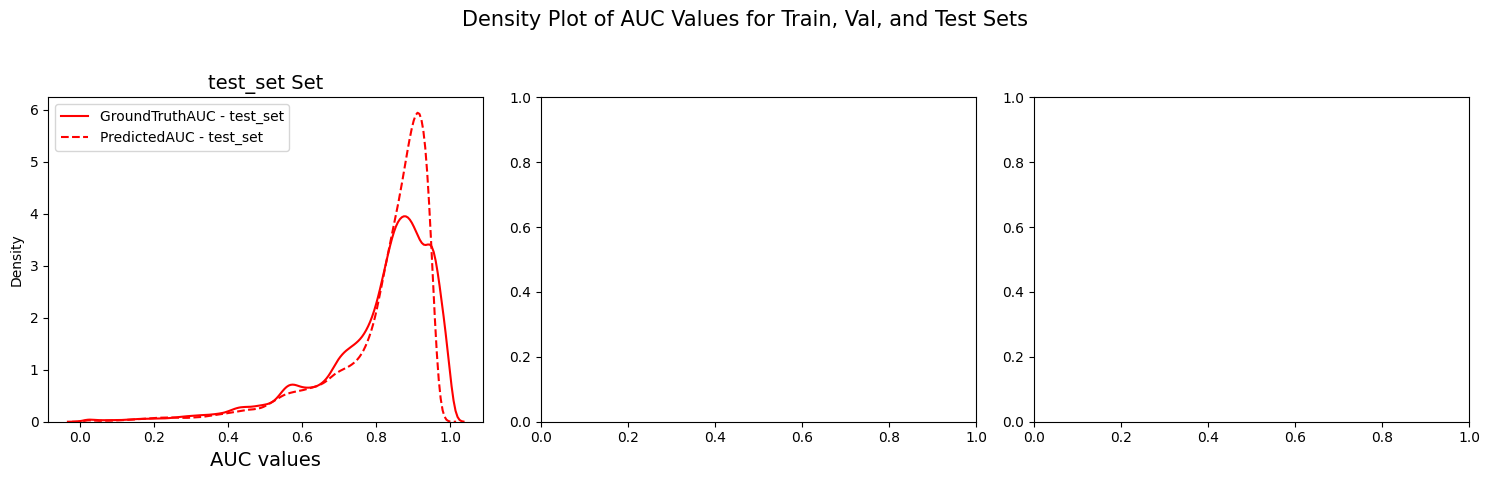

In [12]:
datas = [(eval_targets, eval_outputs, 'test_set', 'red')]
# plot Density_Plot_of_AUC_Values of train val test datasets
hyperparameter_folder_path = None
Density_Plot_of_AUC_Values(datas,hyperparameter_folder_path)

In [13]:
predAUCmatrix_df = pd.read_csv(best_weight_path+"predicted AUC values with UnknownGroundTruth samples.csv", sep=',', index_col=0)

In [14]:
# get index of specific  CCL type
CCLtypeDF = pd.read_csv("../data/CCLE/480CCL all sample types list.txt", sep='\t', index_col=0)
print(CCLtypeDF.shape)
print((set(CCLtypeDF.index)-set(matched_samples)))
CCLtypeDF= (CCLtypeDF.T[matched_samples]).T
print(CCLtypeDF.shape)
Tissue_Type = ['Prostate', 'Ovary and Fallopian Tube', 'Esophagus and Stomach', 
                                    'Pancreas', 'Lung', 'Biliary Tract', 'CNS Brain', 'Breast',
                                    'Bladder or Urinary Tract', 'Thyroid', 'Kidney', 'Head and Neck',
                                    'Uterus', 'Bowel', 'Skin', 'Liver', 'Pleura']

dict = {"Tissue_Type":Tissue_Type, "MAE":[],"Sample_Size":[]}
for type in Tissue_Type:
    type_indices = CCLtypeDF.index[CCLtypeDF["OncotreeLineage"] == type].tolist()
    pred_AUC = np.concatenate(predAUCmatrix_df.loc[type_indices].values)
    GT_AUC = np.concatenate(AUC_df.loc[type_indices].values)
    mask = ~np.isnan(GT_AUC)
    mse = np.mean((pred_AUC[mask] - GT_AUC[mask]) ** 2)
    mae = np.mean(np.abs(pred_AUC[mask] - GT_AUC[mask]))
    dict["MAE"].append(mae)
    dict["Sample_Size"].append(len(type_indices))
print(dict)

(480, 1)
{'ACH-000047', 'ACH-001024', 'ACH-000979', 'ACH-000309'}
(476, 1)
{'Tissue_Type': ['Prostate', 'Ovary and Fallopian Tube', 'Esophagus and Stomach', 'Pancreas', 'Lung', 'Biliary Tract', 'CNS Brain', 'Breast', 'Bladder or Urinary Tract', 'Thyroid', 'Kidney', 'Head and Neck', 'Uterus', 'Bowel', 'Skin', 'Liver', 'Pleura'], 'MAE': [0.055500348075633685, 0.0485586283524407, 0.0502014582123529, 0.04904344476615778, 0.05066156354556618, 0.04881406671936606, 0.04867657644716609, 0.05118140474758243, 0.050445581711218136, 0.05042676377083612, 0.05605183189631337, 0.051997344291454826, 0.051146540690441486, 0.054679054359358485, 0.050934821537192115, 0.05349846224653067, 0.05854536704523107], 'Sample_Size': [3, 30, 40, 33, 92, 7, 34, 22, 23, 9, 17, 23, 23, 27, 39, 17, 9]}


In [15]:
combined_data = list(zip(dict['Tissue_Type'], dict['MAE'], dict['Sample_Size']))
# Sort the list by the MAE value (second element of each tuple)
sorted_dict = sorted(combined_data, key=lambda x: x[1])
# Unzip the sorted dict back into separate lists
sorted_tissue_type, sorted_mae, sorted_sample_size = zip(*sorted_dict)
# Convert back to lists
sorted_tissue_type = list(sorted_tissue_type)
sorted_mae = list(sorted_mae)
sorted_sample_size = list(sorted_sample_size)
# Update the dictionary with sorted values
sorted_data_dict = {'Tissue_Type': sorted_tissue_type,
                    'MAE': sorted_mae,
                    'Sample_Size': sorted_sample_size}
print(sorted_data_dict)

{'Tissue_Type': ['Ovary and Fallopian Tube', 'CNS Brain', 'Biliary Tract', 'Pancreas', 'Esophagus and Stomach', 'Thyroid', 'Bladder or Urinary Tract', 'Lung', 'Skin', 'Uterus', 'Breast', 'Head and Neck', 'Liver', 'Bowel', 'Prostate', 'Kidney', 'Pleura'], 'MAE': [0.0485586283524407, 0.04867657644716609, 0.04881406671936606, 0.04904344476615778, 0.0502014582123529, 0.05042676377083612, 0.050445581711218136, 0.05066156354556618, 0.050934821537192115, 0.051146540690441486, 0.05118140474758243, 0.051997344291454826, 0.05349846224653067, 0.054679054359358485, 0.055500348075633685, 0.05605183189631337, 0.05854536704523107], 'Sample_Size': [30, 34, 7, 33, 40, 9, 23, 92, 39, 23, 22, 23, 17, 27, 3, 17, 9]}


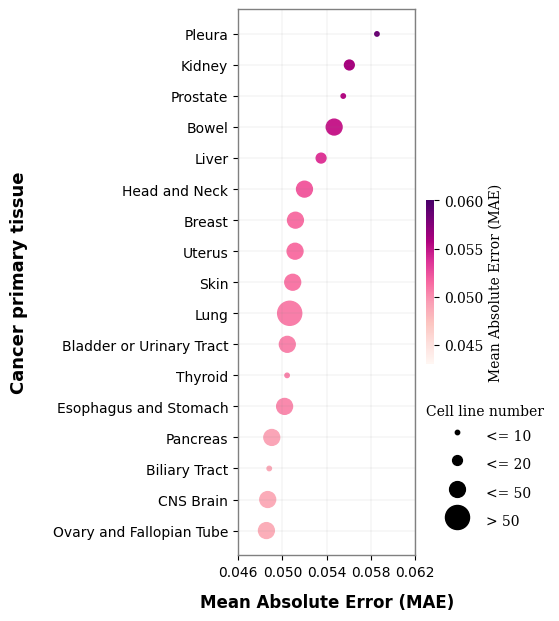

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# Sample data
data = pd.DataFrame(sorted_data_dict)
# Define bubble size
bubble_size = result = [10 if x <= 10 else
                        50 if x <= 20 else
                        130 if x <= 50 else
                        300
                        for x in data['Sample_Size']   ]
# Create figure
fig, ax = plt.subplots(figsize=(5, 6))
plt.rcParams["font.family"] = "serif"
# Scatter plot (bubble plot)
sc = ax.scatter(
    data['MAE'], data['Tissue_Type'], 
    s=bubble_size, c=data['MAE'], cmap='RdPu',vmin=0.043,vmax=0.060)
# Add colorbar
cbar = plt.colorbar(sc, ax=ax,shrink=0.3)
cbar.set_label("Mean Absolute Error (MAE)")
cbar.outline.set_visible(False) # remove the boundary/frame of the colorbar 
# Legend for sample sizes
legend_sizes = [10, 50, 130, 300]  # Example reference sizes
legend_labels = ["<= 10", "<= 20", "<= 50", "> 50"]
legend_handles = [
    plt.scatter([], [], s=size, color='black', label=label)
    for size, label in zip(legend_sizes, legend_labels)]
legend = ax.legend(
    handles=legend_handles, title="Cell line number",
    bbox_to_anchor=(1.8, 0.3),
    handlelength=2.5,        # Length of the legend handles (e.g., lines)
    handleheight=2.0, )
legend.get_frame().set_visible(False)
# Adjust layout to prevent cropping
plt.tight_layout(rect=[0, 0, 1.2, 1])
plt.grid(True, linestyle='-', color='gray', linewidth=0.3, alpha=0.3)
plt.ylabel("Cancer primary tissue", fontsize=13, fontweight="bold", labelpad=18)
plt.xlabel("Mean Absolute Error (MAE)", fontsize=12, fontweight="bold", labelpad=10)
plt.xticks([0.046, 0.050, 0.054, 0.058, 0.062])
for spine in plt.gca().spines.values(): # remove the boundary/frame of the plot 
    spine.set_color('gray')      # Set spine color to gray
    spine.set_linewidth(1)
plt.show()

/tmp/ipykernel_94635/2589213400.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Better default style


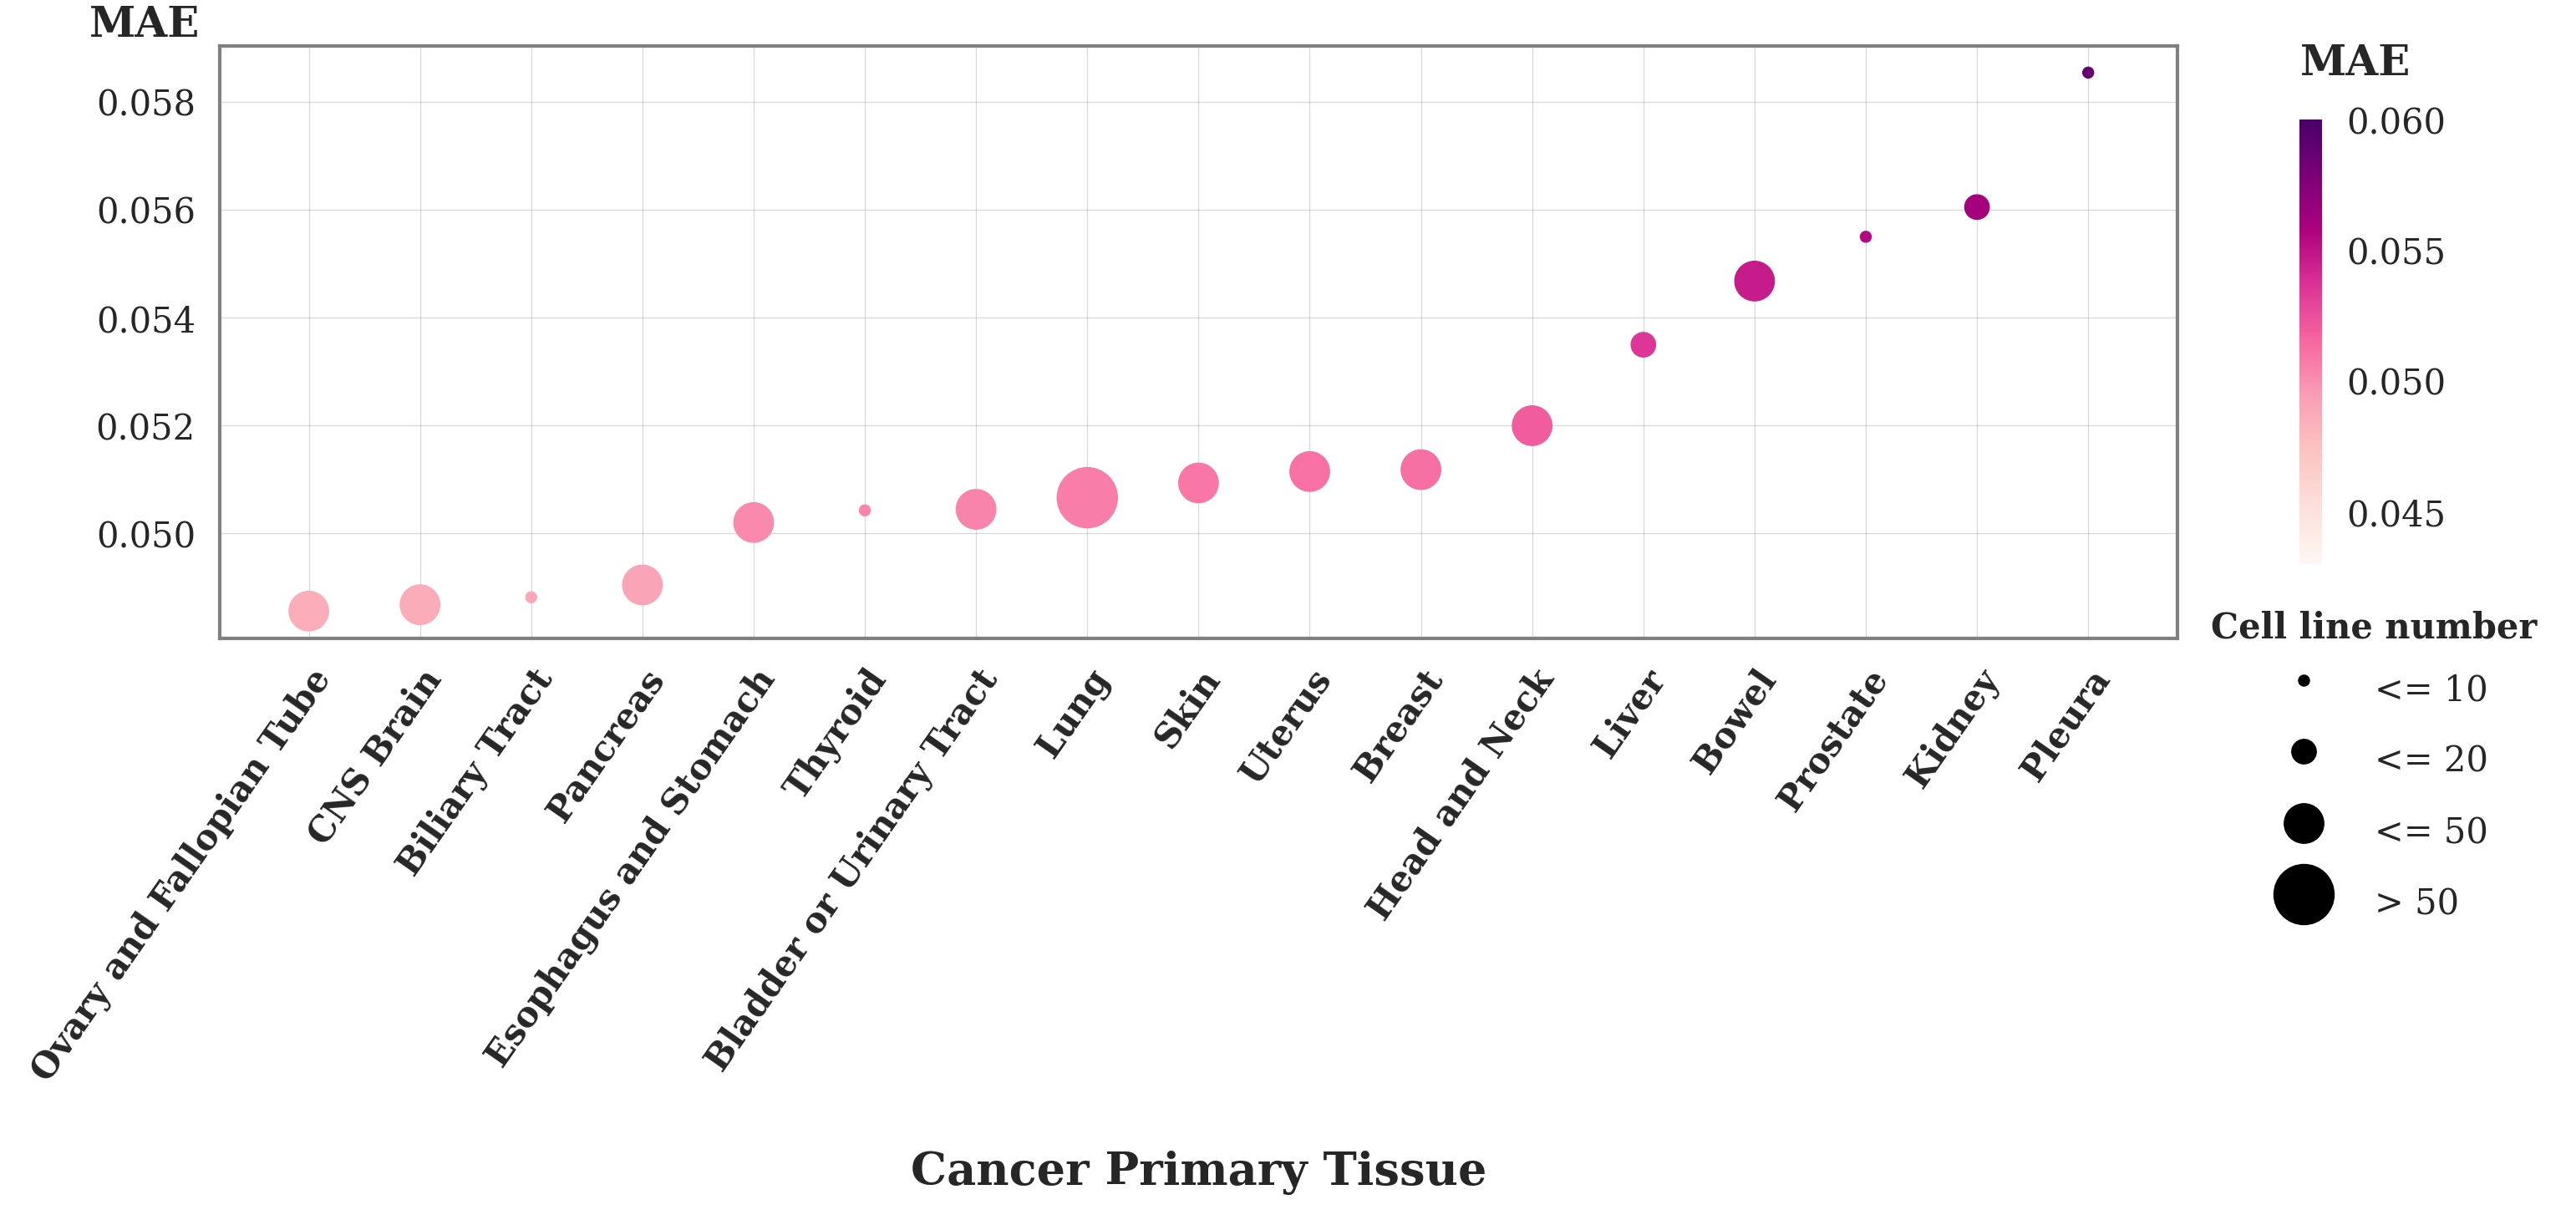

<Figure size 2400x1500 with 0 Axes>

In [17]:
import matplotlib.font_manager as fm
import matplotlib as mpl

# Set up high-quality rendering
plt.style.use('seaborn')  # Better default style
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.dpi'] = 300  # Higher resolution
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['figure.figsize'] = (8, 5)  # Slightly larger figure
mpl.rcParams['path.simplify'] = True
mpl.rcParams['path.simplify_threshold'] = 1.0
mpl.rcParams['agg.path.chunksize'] = 10000
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['svg.fonttype'] = 'none'  # Use system fonts in SVG
plt.rcParams['pdf.fonttype'] = 42  # Use Type 42 (TrueType) fonts
plt.rcParams["font.family"] = "serif"
data = pd.DataFrame(sorted_data_dict)
# Define bubble size
bubble_size = [10 if x <= 10 else
               50 if x <= 20 else
               130 if x <= 50 else
               300 for x in data['Sample_Size']]
# Create figure
fig, ax = plt.subplots(figsize=(6, 3.5))
plt.rcParams["font.family"] = "serif"
# Scatter plot (bubble plot) with swapped axes
sc = ax.scatter(
    data['Tissue_Type'], data['MAE'], 
    s=bubble_size, c=data['MAE'], cmap='RdPu', vmin=0.043, vmax=0.060)
# Add colorbar
cbar = plt.colorbar(sc, ax=ax, shrink=0.75)
cbar.ax.set_xlabel("MAE", fontsize=12, fontweight="bold", labelpad=10)
cbar.ax.xaxis.set_label_position("top") 
cbar.ax.xaxis.set_label_coords(2.5, 1.1)
cbar.outline.set_visible(False)  # Remove boundary/frame of colorbar 
# Legend for sample sizes
legend_sizes = [10, 50, 130, 300]  # Reference sizes
legend_labels = ["<= 10", "<= 20", "<= 50", "> 50"]
legend_handles = [
    plt.scatter([], [], s=size, color='black', label=label)
    for size, label in zip(legend_sizes, legend_labels)]
legend = ax.legend(
    handles=legend_handles, title="Cell line number",title_fontproperties=fm.FontProperties(weight='bold'),
    bbox_to_anchor=(1.2, 0.1),
    handlelength=2.5, handleheight=2.0)
legend.get_frame().set_visible(False)
# Adjust layout to prevent cropping
plt.tight_layout(rect=[0, 0, 1.8, 1.1])
plt.grid(True, linestyle='-', color='gray', linewidth=0.3, alpha=0.3)
# Swap x and y labels
plt.xlabel("Cancer Primary Tissue", fontsize=13, fontweight="bold", labelpad=18)

plt.ylabel("MAE",rotation=0, fontsize=12, fontweight="bold", labelpad=-30, loc='top')

# Adjust x-ticks if needed
plt.xticks(rotation=55, ha='right', rotation_mode='anchor', fontweight="bold")  # Rotate for better readability
# Remove the boundary/frame of the plot
for spine in plt.gca().spines.values():
    spine.set_color('gray')  
    spine.set_linewidth(1)
plt.show()
plt.savefig('./inference/high_quality_MAE horizontal plot.png', format='png', dpi=300)  # High-res raster

In [18]:
ccl_cancer_type = "COAD"
ccl_type = ccl_cancer_type
drug_name = 'FLUOROURACIL (BRD:BRD-K24844714-001-24-5)'
drug_name_short = 'Fluorouracil'
# ENCORAFENIB (BRD:BRD-A56085258-001-01-8): inhibit the mutated BRAF protein
# BINIMETINIB (BRD:BRD-K82244583-001-01-3): inhibit the MEK pathway
# FLUOROURACIL (BRD:BRD-K24844714-001-24-5): TP53
inhibit_Gene = "TP53" # TP53 BRAF KRAS

In [19]:
# get index of specific  CCL type
CCLtypeDF = pd.read_csv("../data/CCLE/480CCL all sample types list(TCGA).txt", sep='\t', index_col=0)
print(CCLtypeDF.shape)
match = sorted(set(CCLtypeDF.index) & set(matched_samples))
print(len(match))
CCLtypeDF= (CCLtypeDF.T[match]).T
print(CCLtypeDF.shape)
type_indices = CCLtypeDF.index[CCLtypeDF["OncotreeCode"] == ccl_cancer_type].tolist()
print(len(type_indices),"\n",type_indices)
print(predAUCmatrix_df.loc[type_indices])

(232, 3)
230
(230, 3)
24 
 ['ACH-000007', 'ACH-000252', 'ACH-000296', 'ACH-000403', 'ACH-000467', 'ACH-000552', 'ACH-000651', 'ACH-000680', 'ACH-000842', 'ACH-000895', 'ACH-000926', 'ACH-000943', 'ACH-000950', 'ACH-000955', 'ACH-000957', 'ACH-000958', 'ACH-000959', 'ACH-000967', 'ACH-000970', 'ACH-000971', 'ACH-000982', 'ACH-000985', 'ACH-000991', 'ACH-000997']
            8-BROMO-CGMP (BRD:BRD-A00077618-236-07-6)  \
CCL                                                     
ACH-000007                                   0.910015   
ACH-000252                                   0.921402   
ACH-000296                                   0.953874   
ACH-000403                                   0.946975   
ACH-000467                                   0.926264   
ACH-000552                                   0.940400   
ACH-000651                                   0.953651   
ACH-000680                                   0.932001   
ACH-000842                                   0.964198   
ACH-00089

In [20]:
# get GT AUC of specific drug and type of ccl

GT_AUC_df_type_drug = (AUC_df.loc[type_indices])[[drug_name]]
print(np.concatenate(GT_AUC_df_type_drug.values).shape)

# get predicted AUC of sepecific drug and type of ccl
predAUCmatrix_df_type_drug = (predAUCmatrix_df.loc[type_indices])[[drug_name]]
print(np.concatenate(predAUCmatrix_df_type_drug.values).shape)
print(predAUCmatrix_df_type_drug.min())
print(predAUCmatrix_df_type_drug)


(24,)
(24,)
FLUOROURACIL (BRD:BRD-K24844714-001-24-5)    0.820826
dtype: float64
            FLUOROURACIL (BRD:BRD-K24844714-001-24-5)
CCL                                                  
ACH-000007                                   0.826396
ACH-000252                                   0.860784
ACH-000296                                   0.890252
ACH-000403                                   0.909988
ACH-000467                                   0.834805
ACH-000552                                   0.885676
ACH-000651                                   0.863027
ACH-000680                                   0.857220
ACH-000842                                   0.876781
ACH-000895                                   0.841144
ACH-000926                                   0.896256
ACH-000943                                   0.820826
ACH-000950                                   0.874847
ACH-000955                                   0.886656
ACH-000957                                   0.869000
A

In [21]:
# get specific mut gene label 0/1
for omic_type in include_omics:
    # Read the file
    omics_data_dict[omic_type] = pd.read_csv(omics_files[omic_type], sep='\t', index_col=0)
    omics_data_dict[omic_type] = omics_data_dict[omic_type].loc[type_indices] #  index of specific CCL type's omics data(contain gene profiles)
    print((omics_data_dict[omic_type]).shape ) 
    if omic_type == "Mut":
        sample_mut_label = ((omics_data_dict[omic_type])[inhibit_Gene] == 1).astype(int).tolist()
        print(sample_mut_label)
    if omic_type == "Exp":# apply Column-wise Min-Max Normalization 
        scaler = StandardScaler() 
        omics_data_dict[omic_type] = pd.DataFrame(scaler.fit_transform(omics_data_dict[omic_type]),index=omics_data_dict[omic_type].index,columns=omics_data_dict[omic_type].columns)
    

(24, 6009)
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1]
(24, 4692)


In [22]:
# get mask from GT_AUC_df_type_drug and get GT_AUC_df_type_drug_dropnan
mask = ~np.isnan(np.concatenate(GT_AUC_df_type_drug.values))
print(mask)
GT_AUC_df_type_drug_dropnan = GT_AUC_df_type_drug.dropna()
GT_AUC_df_type_drug_dropnan.shape

[ True False  True False  True  True False False False False False  True
 False False  True  True  True  True False  True  True False  True  True]


(13, 1)

In [23]:
# get mutation label after mask for GT boxplot
GT_mut_label_masked=np.array(sample_mut_label)[mask] # 1:w ; 0:wo
print("GT_mut_label_masked",GT_mut_label_masked)
# turn 0/1 to 'w/o TP53_Mut'/'TP53_Mut'
GT_mut_label_masked = [f'{inhibit_Gene}_Mut' if label == 1 else f'w/o {inhibit_Gene}_Mut' for label in GT_mut_label_masked]
print(len(GT_mut_label_masked),"\n",GT_mut_label_masked)
sample_mut_label = [f'{inhibit_Gene}_Mut' if label == 1 else f'w/o {inhibit_Gene}_Mut' for label in sample_mut_label]
print("sample_mut_label\n",sample_mut_label)
print(len(sample_mut_label))

GT_mut_label_masked [0 1 1 1 0 0 0 1 1 0 0 1 1]
13 
 ['w/o TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'w/o TP53_Mut', 'w/o TP53_Mut', 'w/o TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'w/o TP53_Mut', 'w/o TP53_Mut', 'TP53_Mut', 'TP53_Mut']
sample_mut_label
 ['w/o TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'w/o TP53_Mut', 'w/o TP53_Mut', 'TP53_Mut', 'w/o TP53_Mut', 'w/o TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'w/o TP53_Mut', 'w/o TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'TP53_Mut']
24


/tmp/ipykernel_94635/2415314854.py:40: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)
/tmp/ipykernel_94635/2415314854.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="mutation_status", y="predicted AUC", data=df, palette=custom_palette)
/tmp/ipykernel_94635/2415314854.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="mutation_status", y="GroundTruth AUC", data=GTdf, palette=custom_palette)


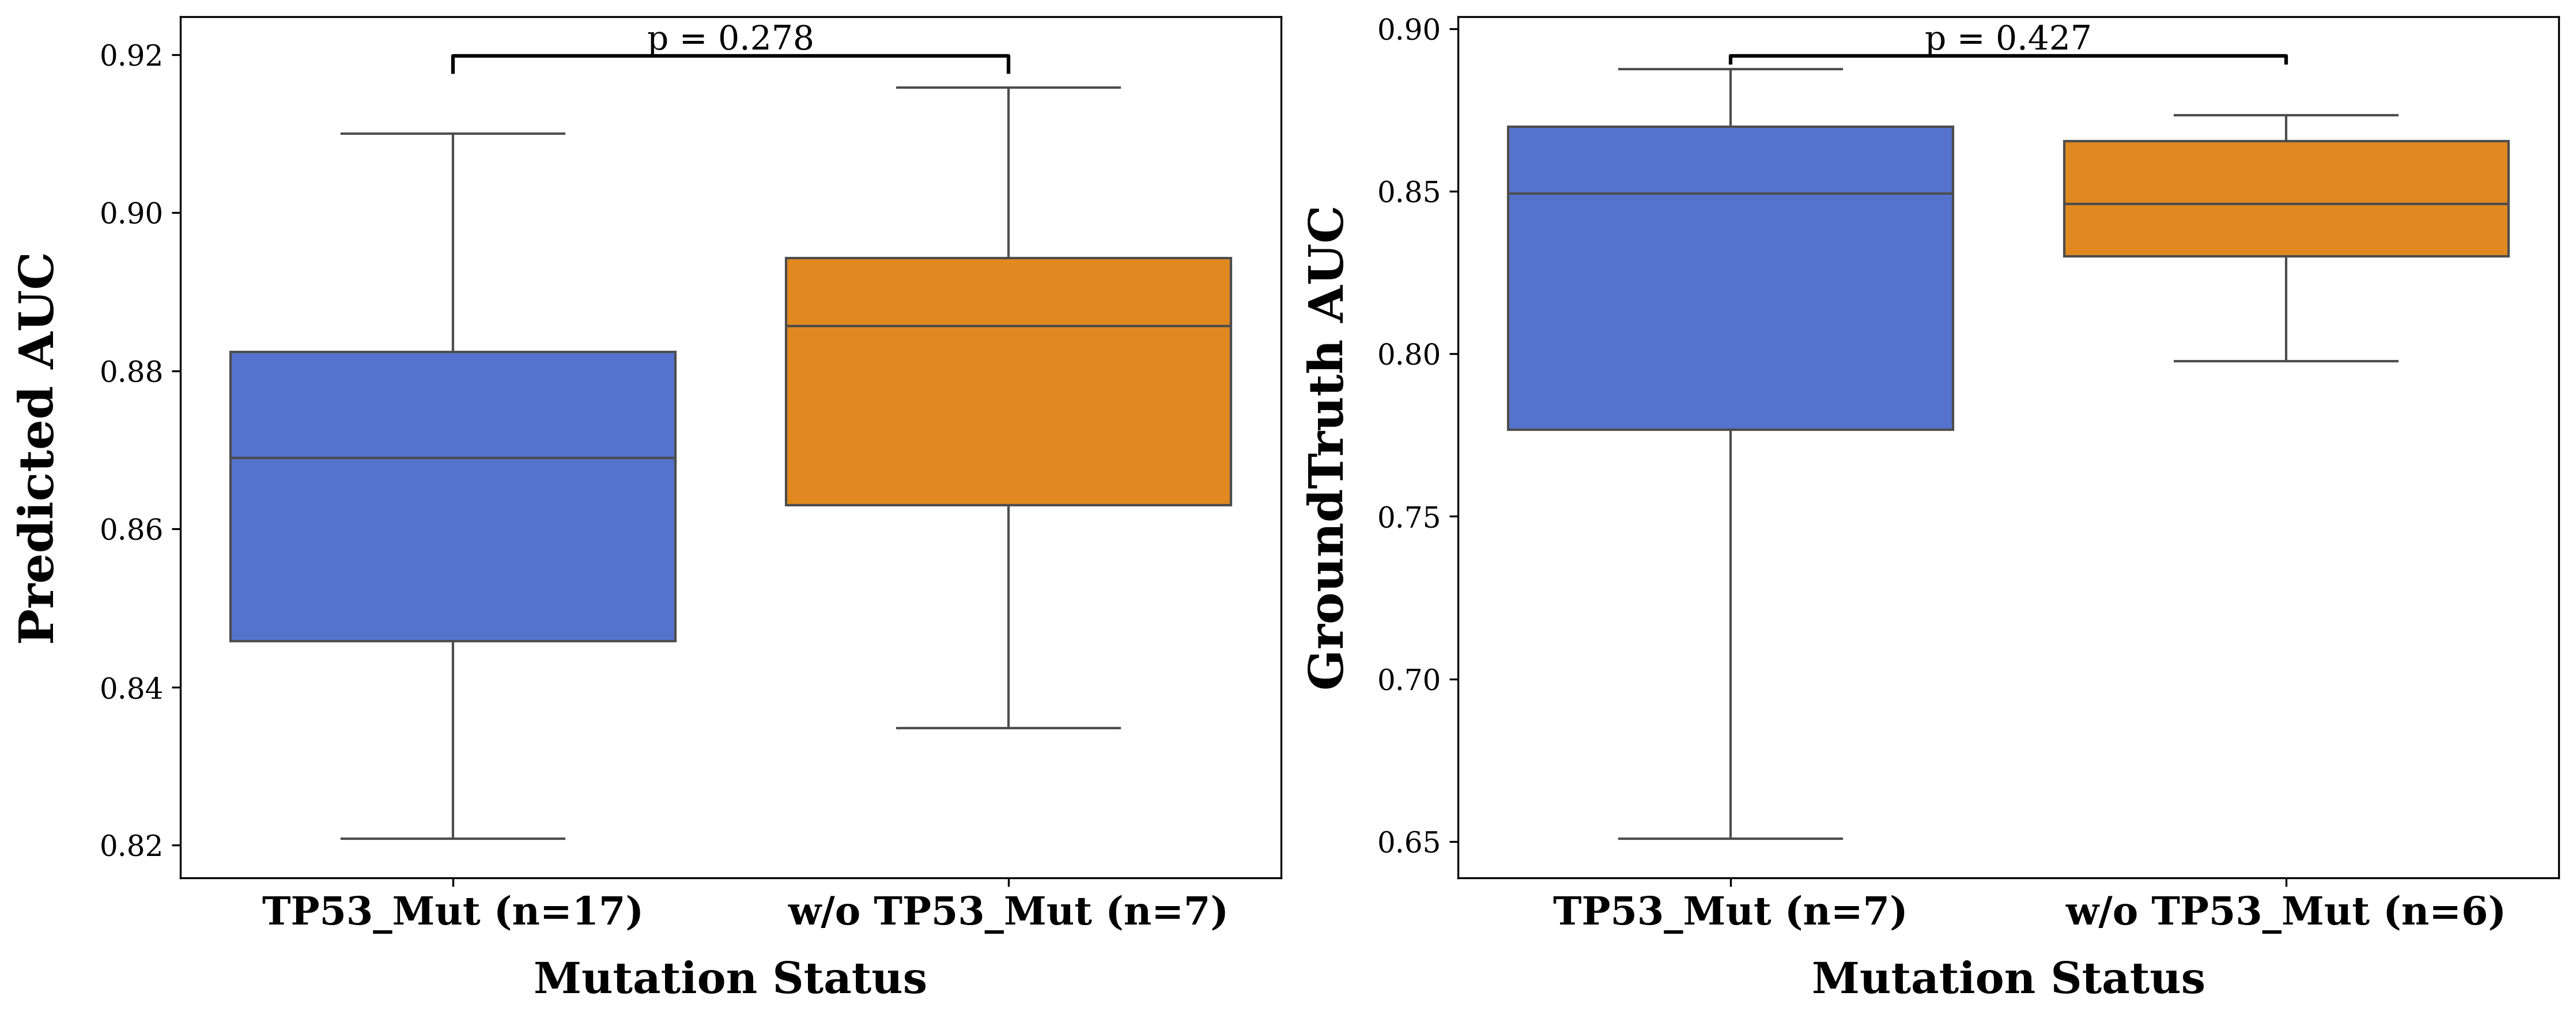

<Figure size 4500x1800 with 0 Axes>

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.font_manager as fm
import matplotlib as mpl

# Set up high-quality rendering
# plt.style.use('seaborn')  # Better default style
plt.style.use('default')  # Use default style instead of seaborn
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.dpi'] = 300  # Higher resolution
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['figure.figsize'] = (15, 6)  # Slightly larger figure
mpl.rcParams['path.simplify'] = True
mpl.rcParams['path.simplify_threshold'] = 1.0
mpl.rcParams['agg.path.chunksize'] = 10000
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['svg.fonttype'] = 'none'  # Use system fonts in SVG
plt.rcParams['pdf.fonttype'] = 42  # Use Type 42 (TrueType) fonts
plt.rcParams["font.family"] = "serif"


plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'black'  # Explicitly set edge color
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(True)
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')  # or any color you prefer
    spine.set_linewidth(1)  # adjust thickness as needed

# fig=plt.figure(figsize=(15,6))
plt.rcParams["font.family"] = "serif"
fig.suptitle(f'Comparison of {drug_name_short} treatment AUC response \n between {inhibit_Gene}-mutated and non-mutated {ccl_cancer_type} samples',fontsize=18, fontweight='bold',y=1.01,linespacing=1.5)

plt.subplot(1,2,1)
df = pd.DataFrame({'predicted AUC': np.concatenate(predAUCmatrix_df_type_drug.values) , 'mutation_status': sample_mut_label})
# Perform t-test
group1 = df[df["mutation_status"] == f'w/o {inhibit_Gene}_Mut']["predicted AUC"]
group2 = df[df["mutation_status"] == f'{inhibit_Gene}_Mut']["predicted AUC"]
t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)  # Welch’s t-test
custom_palette = {f'w/o {inhibit_Gene}_Mut': "royalblue", f'{inhibit_Gene}_Mut': "darkorange"}
ax = sns.boxplot(x="mutation_status", y="predicted AUC", data=df, palette=custom_palette)
# Annotate significance
x1, x2 = 0, 1  # Positions of the two boxplots
y, h = df["predicted AUC"].max() + 0.002, 0.002  # Adjust position
plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c='k')
plt.text((x1 + x2) / 2, y + h, f"p = {p_value:.3g}", ha='center', va='bottom', fontsize=14)
plt.xticks([1, 0], [f'w/o {inhibit_Gene}_Mut (n={len(group1)})', f'{inhibit_Gene}_Mut (n={len(group2)})'], fontsize=15, fontweight='bold')
# plt.title(f'Comparison of {drug_name_short} treatment Predicted AUC \n between {inhibit_Gene}-mutated and non-mutated {ccl_cancer_type} samples',fontsize=18, fontweight='bold')
plt.xlabel('Mutation Status', fontsize=18, fontweight='bold', labelpad=11)
plt.ylabel('Predicted AUC', fontsize=20, fontweight='bold', labelpad=15)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=12)

plt.subplot(1,2,2)
GTdf = pd.DataFrame({'GroundTruth AUC': np.concatenate(GT_AUC_df_type_drug_dropnan.values) , 'mutation_status': GT_mut_label_masked})
group1 = GTdf[GTdf["mutation_status"] == f"w/o {inhibit_Gene}_Mut"]["GroundTruth AUC"]
group2 = GTdf[GTdf["mutation_status"] == f"{inhibit_Gene}_Mut"]["GroundTruth AUC"]
t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)  # Welch’s t-test
custom_palette = {f"w/o {inhibit_Gene}_Mut": "royalblue", f"{inhibit_Gene}_Mut": "darkorange"}
ax = sns.boxplot(x="mutation_status", y="GroundTruth AUC", data=GTdf, palette=custom_palette)
# Annotate significance
x1, x2 = 0, 1  # Positions of the two boxplots
y, h = GTdf["GroundTruth AUC"].max() + 0.002, 0.002  # Adjust position
plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c='k')
plt.text((x1 + x2) / 2, y + h, f"p = {p_value:.3g}", ha='center', va='bottom', fontsize=14)
plt.xticks([1, 0], [f'w/o {inhibit_Gene}_Mut (n={len(group1)})', f'{inhibit_Gene}_Mut (n={len(group2)})'], fontsize=15, fontweight='bold')
plt.xlabel('Mutation Status', fontsize=18, fontweight='bold', labelpad=11)
plt.ylabel('GroundTruth AUC', fontsize=20, fontweight='bold', labelpad=10)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=12)
# plt.title(f'Comparison of {drug_name_short} treatment Ground Truth AUC \n between {inhibit_Gene}-mutated and non-mutated {ccl_cancer_type} samples',fontsize=18, fontweight='bold')
plt.show()
plt.savefig('./inference/high_quality_TP53 COAD 5Flu.png', format='png', dpi=300)  # High-res raster

In [29]:
predAUCmatrix_df = pd.read_csv(best_weight_path+"predicted AUC values with UnknownGroundTruth samples.csv", sep=',', index_col=0)

In [28]:
drug_ID = "BRD-K24844714-001-24-5"
cell_ID = "ACH-000007"
ccl_cancer_type = "COAD"
ccl_type = ccl_cancer_type
drug_name = 'FLUOROURACIL (BRD:BRD-K24844714-001-24-5)'
drug_name_short = 'Fluorouracil'
# ENCORAFENIB (BRD:BRD-A56085258-001-01-8): inhibit the mutated BRAF protein
# BINIMETINIB (BRD:BRD-K82244583-001-01-3): inhibit the MEK pathway
# FLUOROURACIL (BRD:BRD-K24844714-001-24-5): TP53 
inhibit_Gene = "TP53" # TP53 BRAF KRAS

In [29]:
for omic_type in include_omics:
    # Read the file
    omics_data_dict[omic_type] = pd.read_csv(omics_files[omic_type], sep='\t', index_col=0)
    print((omics_data_dict[omic_type]).shape )
    if omic_type == "Mut":
        sample_mut_label = ((omics_data_dict[omic_type])[inhibit_Gene] == 1).astype(int).tolist()
        print(sample_mut_label)
    if omic_type == "Exp":# apply Column-wise Min-Max Normalization 
        scaler = StandardScaler() 
        omics_data_dict[omic_type] = pd.DataFrame(scaler.fit_transform(omics_data_dict[omic_type]),index=omics_data_dict[omic_type].index,columns=omics_data_dict[omic_type].columns)
    
    omics_data_dict[omic_type] = (omics_data_dict[omic_type].loc[cell_ID])#.reshape(1, -1)#  index of specific CCL's omics data(contain gene profiles)
    print((omics_data_dict[omic_type]) )

    omics_data_tensor_dict[omic_type]  = torch.tensor(omics_data_dict[omic_type], dtype=torch.float32).to(device).reshape(1, -1)
    omics_numfeatures_dict[omic_type] = omics_data_tensor_dict[omic_type].shape[1]#[1]
 
    print(f"{omic_type} tensor shape:", omics_data_tensor_dict[omic_type].shape)
    print(f"{omic_type} num_features",omics_numfeatures_dict[omic_type])

    

(476, 6009)
[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 

/tmp/ipykernel_94635/1814236216.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  omics_data_tensor_dict[omic_type]  = torch.tensor(omics_data_dict[omic_type], dtype=torch.float32).to(device).reshape(1, -1)


(476, 4692)
A1BG      -1.197185
A2M       -0.382885
A2ML1     -0.386410
A4GALT    -1.637404
AADAT      0.219333
             ...   
ZNF91      0.946743
ZNF93     -1.148618
ZP3        0.239061
ZSCAN18   -1.211686
ZWINT     -0.414245
Name: ACH-000007, Length: 4692, dtype: float64
Exp tensor shape: torch.Size([1, 4692])
Exp num_features 4692


/tmp/ipykernel_94635/1814236216.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  omics_data_tensor_dict[omic_type]  = torch.tensor(omics_data_dict[omic_type], dtype=torch.float32).to(device).reshape(1, -1)


In [30]:
drug_df= pd.read_csv("../data/no_Imputation_PRISM_Repurposing_Secondary_Screen_data/MACCS(Secondary_Screen_treatment_info)_union_NOrepeat.csv", sep=',', index_col=0)
AUC_df = pd.read_csv("../data/no_Imputation_PRISM_Repurposing_Secondary_Screen_data/Drug_sensitivity_AUC_(PRISM_Repurposing_Secondary_Screen)_subsetted_NOrepeat.csv", sep=',', index_col=0)
# matched AUCfile and omics_data samples

# matched_samples = sorted(set(AUC_df.T.columns) & set(list(omics_data_dict.values())[0].T.columns))
# AUC_df= (AUC_df.T[matched_samples]).T

print("AUC_df",AUC_df.shape)
if AUCtransform == "-log2":
    AUC_df = -np.log2(AUC_df)
if AUCtransform == "-log10":
    AUC_df = -np.log10(AUC_df)
    
print("drug_df",drug_df.shape)
print("AUC_df",AUC_df.shape)

AUC_df (480, 1440)
drug_df (1440, 9)
AUC_df (480, 1440)


In [31]:
# get specific drug and ccl
drug_df= drug_df[drug_df['BRD_ID'] == drug_ID]
print(drug_df)
print("\n")
#get pair GT response 
matching_columns_name = [col for col in AUC_df.loc[cell_ID].index if drug_ID in col]
print("matching_columns_name", matching_columns_name)

GT_AUC_df_pair = (AUC_df.loc[cell_ID])[matching_columns_name] # MK-5108 (BRD:BRD-K53665955-001-03-0)
print("GT_AUC_df_pair\n",GT_AUC_df_pair)
#get pair predicted response 
predAUCmatrix_df_pair = (predAUCmatrix_df.loc[cell_ID])[matching_columns_name]
print("predAUCmatrix_df_pair\n",predAUCmatrix_df_pair)

                              BRD_ID            name  \
Name                                                   
FLUOROURACIL  BRD-K24844714-001-24-5  5-fluorouracil   

                                         moa      target disease.area  \
Name                                                                    
FLUOROURACIL  thymidylate synthase inhibitor  DPYD, TYMS     oncology   

                                                     indication     phase  \
Name                                                                        
FLUOROURACIL  colorectal cancer, breast cancer, pancreatic c...  Launched   

                             smiles  \
Name                                  
FLUOROURACIL  Fc1c[nH]c(=O)[nH]c1=O   

                                                   MACCS166bits  
Name                                                             
FLUOROURACIL  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...  


matching_columns_name ['FLUOROURACIL (BRD:BRD-K24844714-001-2

In [32]:
if ESPF is True:
    drug_smiles =drug_df["smiles"] # 
    drug_names =drug_df.index
    # 挑出重複的SMILES
    duplicate =  drug_smiles[drug_smiles.duplicated(keep=False)]

    #--------------------------------------------------------------------------------------------------------------------------
    #ESPF
    vocab_path = "./ESPF/drug_codes_chembl_freq_1500.txt" # token
    sub_csv = pd.read_csv("./ESPF/subword_units_map_chembl_freq_1500.csv")# token with frequency

    # 將drug_smiles 使用_drug2emb_encoder function編碼成subword vector
    drug_encode = pd.Series(drug_smiles).apply(drug2emb_encoder, args=(vocab_path, sub_csv, max_drug_len))

    drug_features_tensor = torch.tensor(np.array([i[:2] for i in drug_encode.values]), dtype=torch.long).to(device)
else:
    drug_encode = drug_df["MACCS166bits"]
    drug_encode_list = [list(map(int, item.split(','))) for item in drug_encode.values]
    print("MACCS166bits_drug_encode_list type: ",type(drug_encode_list))
    # Convert your data to tensors if they're in numpy
    drug_features_tensor = torch.tensor(np.array(drug_encode_list), dtype=torch.long).to(device)
#--------------------------------------------------------------------------------------------------------------------------
num_ccl = list(omics_data_tensor_dict.values())[0].shape[0]
num_drug = drug_encode.shape[0]
print("num_ccl,num_drug: ",num_ccl,num_drug)

response_matrix_tensor = torch.tensor(GT_AUC_df_pair.values, dtype=torch.float32).to(device).unsqueeze(1)
print(omics_data_tensor_dict)
print(drug_features_tensor.shape)# Fc1c[nH]c(=O)[nH]c1=O 
print(response_matrix_tensor.shape)
print(drug_encode.values[0][2])

num_ccl,num_drug:  1 1
{'Mut': tensor([[0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0'), 'Exp': tensor([[-1.1972, -0.3829, -0.3864,  ...,  0.2391, -1.2117, -0.4142]],
       device='cuda:0')}
torch.Size([1, 2, 50])
torch.Size([1, 1])
['F', 'c1c[nH]', 'c', '(=O)', '[nH]', 'c1', '=O']


In [33]:
if 'weighted' in criterion.loss_type :    
    # Set threshold based on the 90th percentile # 將高於threshold的AUC權重增加
    weighted_threshold = np.nanpercentile(AUC_df.values, 90)    
    total_samples = (~np.isnan(AUC_df.values)).sum().item()
    fewWt_samples = (AUC_df.values > weighted_threshold).sum().item()
    moreWt_samples = total_samples - fewWt_samples
    few_weight = total_samples / (2 * fewWt_samples)  
    more_weight = total_samples / (2 * moreWt_samples)   
else:
    weighted_threshold = None
    few_weight = None
    more_weight = None
print("weighted_threshold:",weighted_threshold)

weighted_threshold: None


In [34]:
set_seed(seed)
dataset = OmicsDrugDataset(omics_data_tensor_dict, drug_features_tensor, response_matrix_tensor, splitType, include_omics)
one_loader = DataLoader(dataset, batch_size=1, shuffle=False)

self.num_drugs 1


In [38]:
%%time
# Evaluation
if model_name == "Omics_DrugESPF_Model":
    model = Omics_DrugESPF_Model(omics_encode_dim_dict, drug_encode_dims, activation_func, activation_func_final, dense_layer_dim, device, ESPF, Drug_SelfAttention, pos_emb_type,
                        drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,
                        n_layer,TCGA_pretrain_weight_path_dict= TCGA_pretrain_weight_path_dict)
elif model_name == "Omics_DCSA_Model":
    model = Omics_DCSA_Model(omics_encode_dim_dict, drug_encode_dims, activation_func, activation_func_final, dense_layer_dim, device, ESPF, Drug_SelfAttention, pos_emb_type,
                        drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,
                        n_layer,TCGA_pretrain_weight_path_dict= TCGA_pretrain_weight_path_dict)
model.to(device=device)
# best_weight_path = './inference/BF1_test_loss0.0562689_BestValEpo21_ModelOmics_DCSA_Model_byCCL_OmicsMut_Exp_ESPFTrue_DrugSelfAttentionFalse/'
best_weight = best_weight_path + "BestValWeight.pt"

model.load_state_dict(torch.load(best_weight))

# eval_targets, eval_outputs,predAUCwithUnknownGT, AttenScorMat_DrugSelf, AttenScorMat_DrugCellSelf,eval_outputs_before_final_activation_list, mean_batch_eval_lossWOpenalty
(eval_targets, eval_outputs,predAUCwithUnknownGT,
 AttenScorMat_DrugSelf ,AttenScorMat_DrugCellSelf,
 _, 
 _)  = evaluation(model, None,None,
                                             criterion, one_loader, device,ESPF,Drug_SelfAttention, 
                                             weighted_threshold, few_weight, more_weight, 
                                             outputcontrol='inference')


State_dict for Sequential(
  (0): Linear(in_features=6009, out_features=1000, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1000, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=50, bias=True)
) loaded successfully.
State_dict for Sequential(
  (0): Linear(in_features=4692, out_features=1000, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1000, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=50, bias=True)
) loaded successfully.

 Drug_SelfAttention is applied 

CPU times: user 631 ms, sys: 41.9 ms, total: 673 ms
Wall time: 3.78 s


In [39]:
# drug selfattention
print(AttenScorMat_DrugSelf.shape)
# average the 8head attention score matrix
AttenScorMat_DrugSelf = AttenScorMat_DrugSelf.mean(dim=1).squeeze(0)# torch.Size([bsz, 8, 50, 50])
# ==>[bsz, 50, 50]
print(AttenScorMat_DrugSelf.shape)

# DrugCell selfattention
print(AttenScorMat_DrugCellSelf.shape)
# average the 8head attention score matrix
AttenScorMat_DrugCellSelf = AttenScorMat_DrugCellSelf.mean(dim=1).squeeze(0)# torch.Size([bsz, 8, 50, 50])
# ==>[bsz, 50, 50]
print(AttenScorMat_DrugCellSelf.shape)

torch.Size([1, 8, 50, 50])
torch.Size([50, 50])
torch.Size([1, 8, 52, 52])
torch.Size([52, 52])


In [52]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
def heatmap(attention_scores_Matrix, drug_ID, cell_ID,drug_name_short,ccl_type, include_omics ,fontsize_ticks=12, module="", sub=None ):

    # Set up high-quality rendering
    # plt.style.use('seaborn')  # Better default style
    plt.style.use('default')  # Use default style instead of seaborn
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['axes.facecolor'] = 'white'
    mpl.rcParams['figure.dpi'] = 300  # Higher resolution
    mpl.rcParams['savefig.dpi'] = 300
    mpl.rcParams['figure.figsize'] = (10, 10)  # Slightly larger figure
    mpl.rcParams['path.simplify'] = True
    mpl.rcParams['path.simplify_threshold'] = 1.0
    mpl.rcParams['agg.path.chunksize'] = 10000
    plt.rcParams['figure.autolayout'] = True
    plt.rcParams['figure.constrained_layout.use'] = True
    plt.rcParams['svg.fonttype'] = 'none'  # Use system fonts in SVG
    plt.rcParams['pdf.fonttype'] = 42  # Use Type 42 (TrueType) fonts
    plt.rcParams["font.family"] = "serif"
    
    # Define the colors and their corresponding positions (anchors)
    colors = ["#67749f","#6581b2","#b4d5e5", "white","#fae19b","#e9a94f", "red","#a10318"]  # Color sequence
    anchors = [0.0,0.1, 0.35,0.5,0.55,0.75,0.9, 1.0]  # Position of each color (0 = min, 1 = max)

    # Create a custom colormap with specified anchors
    custom_cmap = LinearSegmentedColormap.from_list("custom_heatmap", list(zip(anchors, colors)))
    # plt.figure(figsize=(10, 8))
    plt.rcParams["font.family"] = "serif"
    plt.imshow(attention_scores_Matrix, aspect="auto", cmap=custom_cmap, vmin=1, vmax=0) # make all color correspond to the specific value
    cbar = plt.colorbar(label="attention score")
    cbar.ax.yaxis.label.set_weight("bold")  # Make label bold
    cbar.ax.set_ylabel("Attention Score", fontsize=20)
    cbar.outline.set_visible(False) # remove the boundary/frame of the colorbar 
    

    # Set x and y axis labels
    if module == "AttenScorMat_DrugSelf":
        plt.xlabel("Drug Substructures", fontsize=20, fontweight='bold', fontname="serif")
        plt.ylabel("Drug Substructures", fontsize=20, fontweight='bold', fontname="serif")
    if module == "AttenScorMat_DrugCellSelf":
        plt.xlabel(f"Substructures_number: {len(drug_encode.values[0][2])}", fontsize=20, fontweight='bold', fontname="serif")
        plt.ylabel(f"Substructures_number: {len(drug_encode.values[0][2])}", fontsize=20, fontweight='bold', fontname="serif")
        
    # Optionally, set the x and y ticks (example with some labels)
    if module == "AttenScorMat_DrugSelf":
        plt.title(f"{drug_ID} \n SelfAttention Score Matrix\n {drug_name_short} - {ccl_type} cell line", fontsize=22, fontweight='bold',y=1.01,linespacing=1.7)
        if sub is not None:
             # Add text annotations for each cell
            rows, cols = attention_scores_Matrix.shape
            for i in range(rows):
                for j in range(cols):
                    plt.text(j, i, f"{attention_scores_Matrix[i, j]:.3f}",  # Format to 2 decimal places
                            ha="center", va="center", color="black", fontsize=12)
            plt.xticks(fontsize=fontsize_ticks,fontweight="bold",rotation=75, ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=([f"{i}" for i in sub]) ) 
            plt.yticks(fontsize=fontsize_ticks,fontweight="bold",ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=([f"{i}" for i in sub]) ) 
        else:
            plt.xticks(fontsize=fontsize_ticks,fontweight="bold",rotation=75, ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=[f"sub{i+1}" for i in range(attention_scores_Matrix.shape[1])])
            plt.yticks(fontsize=fontsize_ticks,fontweight="bold",ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=[f"sub{i+1}" for i in range(attention_scores_Matrix.shape[1])])
            
    if module == "AttenScorMat_DrugCellSelf":
        plt.title(f"{drug_ID} - {cell_ID} \n SelfAttention Score Matrix \n {drug_name_short} - {ccl_type} cell line", fontsize=22, fontweight='bold',y=1.01,linespacing=1.7)
        if sub is not None:
             # Add text annotations for each cell
            rows, cols = attention_scores_Matrix.shape
            for i in range(rows):
                for j in range(cols):
                    plt.text(j, i, f"{attention_scores_Matrix[i, j]:.3f}",  # Format to 2 decimal places
                            ha="center", va="center", color="black", fontsize=12)
            plt.xticks(fontsize=fontsize_ticks,fontweight="bold",rotation=75, ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=([f"{i}" for i in sub] + include_omics) ) 
            plt.yticks(fontsize=fontsize_ticks,fontweight="bold",ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=([f"{i}" for i in sub] + include_omics) ) 
        else:
            plt.xticks(fontsize=fontsize_ticks,fontweight="bold",rotation=75, ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=([f"sub{i+1}" for i in range(attention_scores_Matrix.shape[1]-len(include_omics))] + include_omics) ) 
            plt.yticks(fontsize=fontsize_ticks,fontweight="bold",ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=([f"sub{i+1}" for i in range(attention_scores_Matrix.shape[1]-len(include_omics))] + include_omics) ) 
        
        
    for spine in plt.gca().spines.values(): # remove the boundary/frame of the plot 
        spine.set_visible(False)
    plt.show()

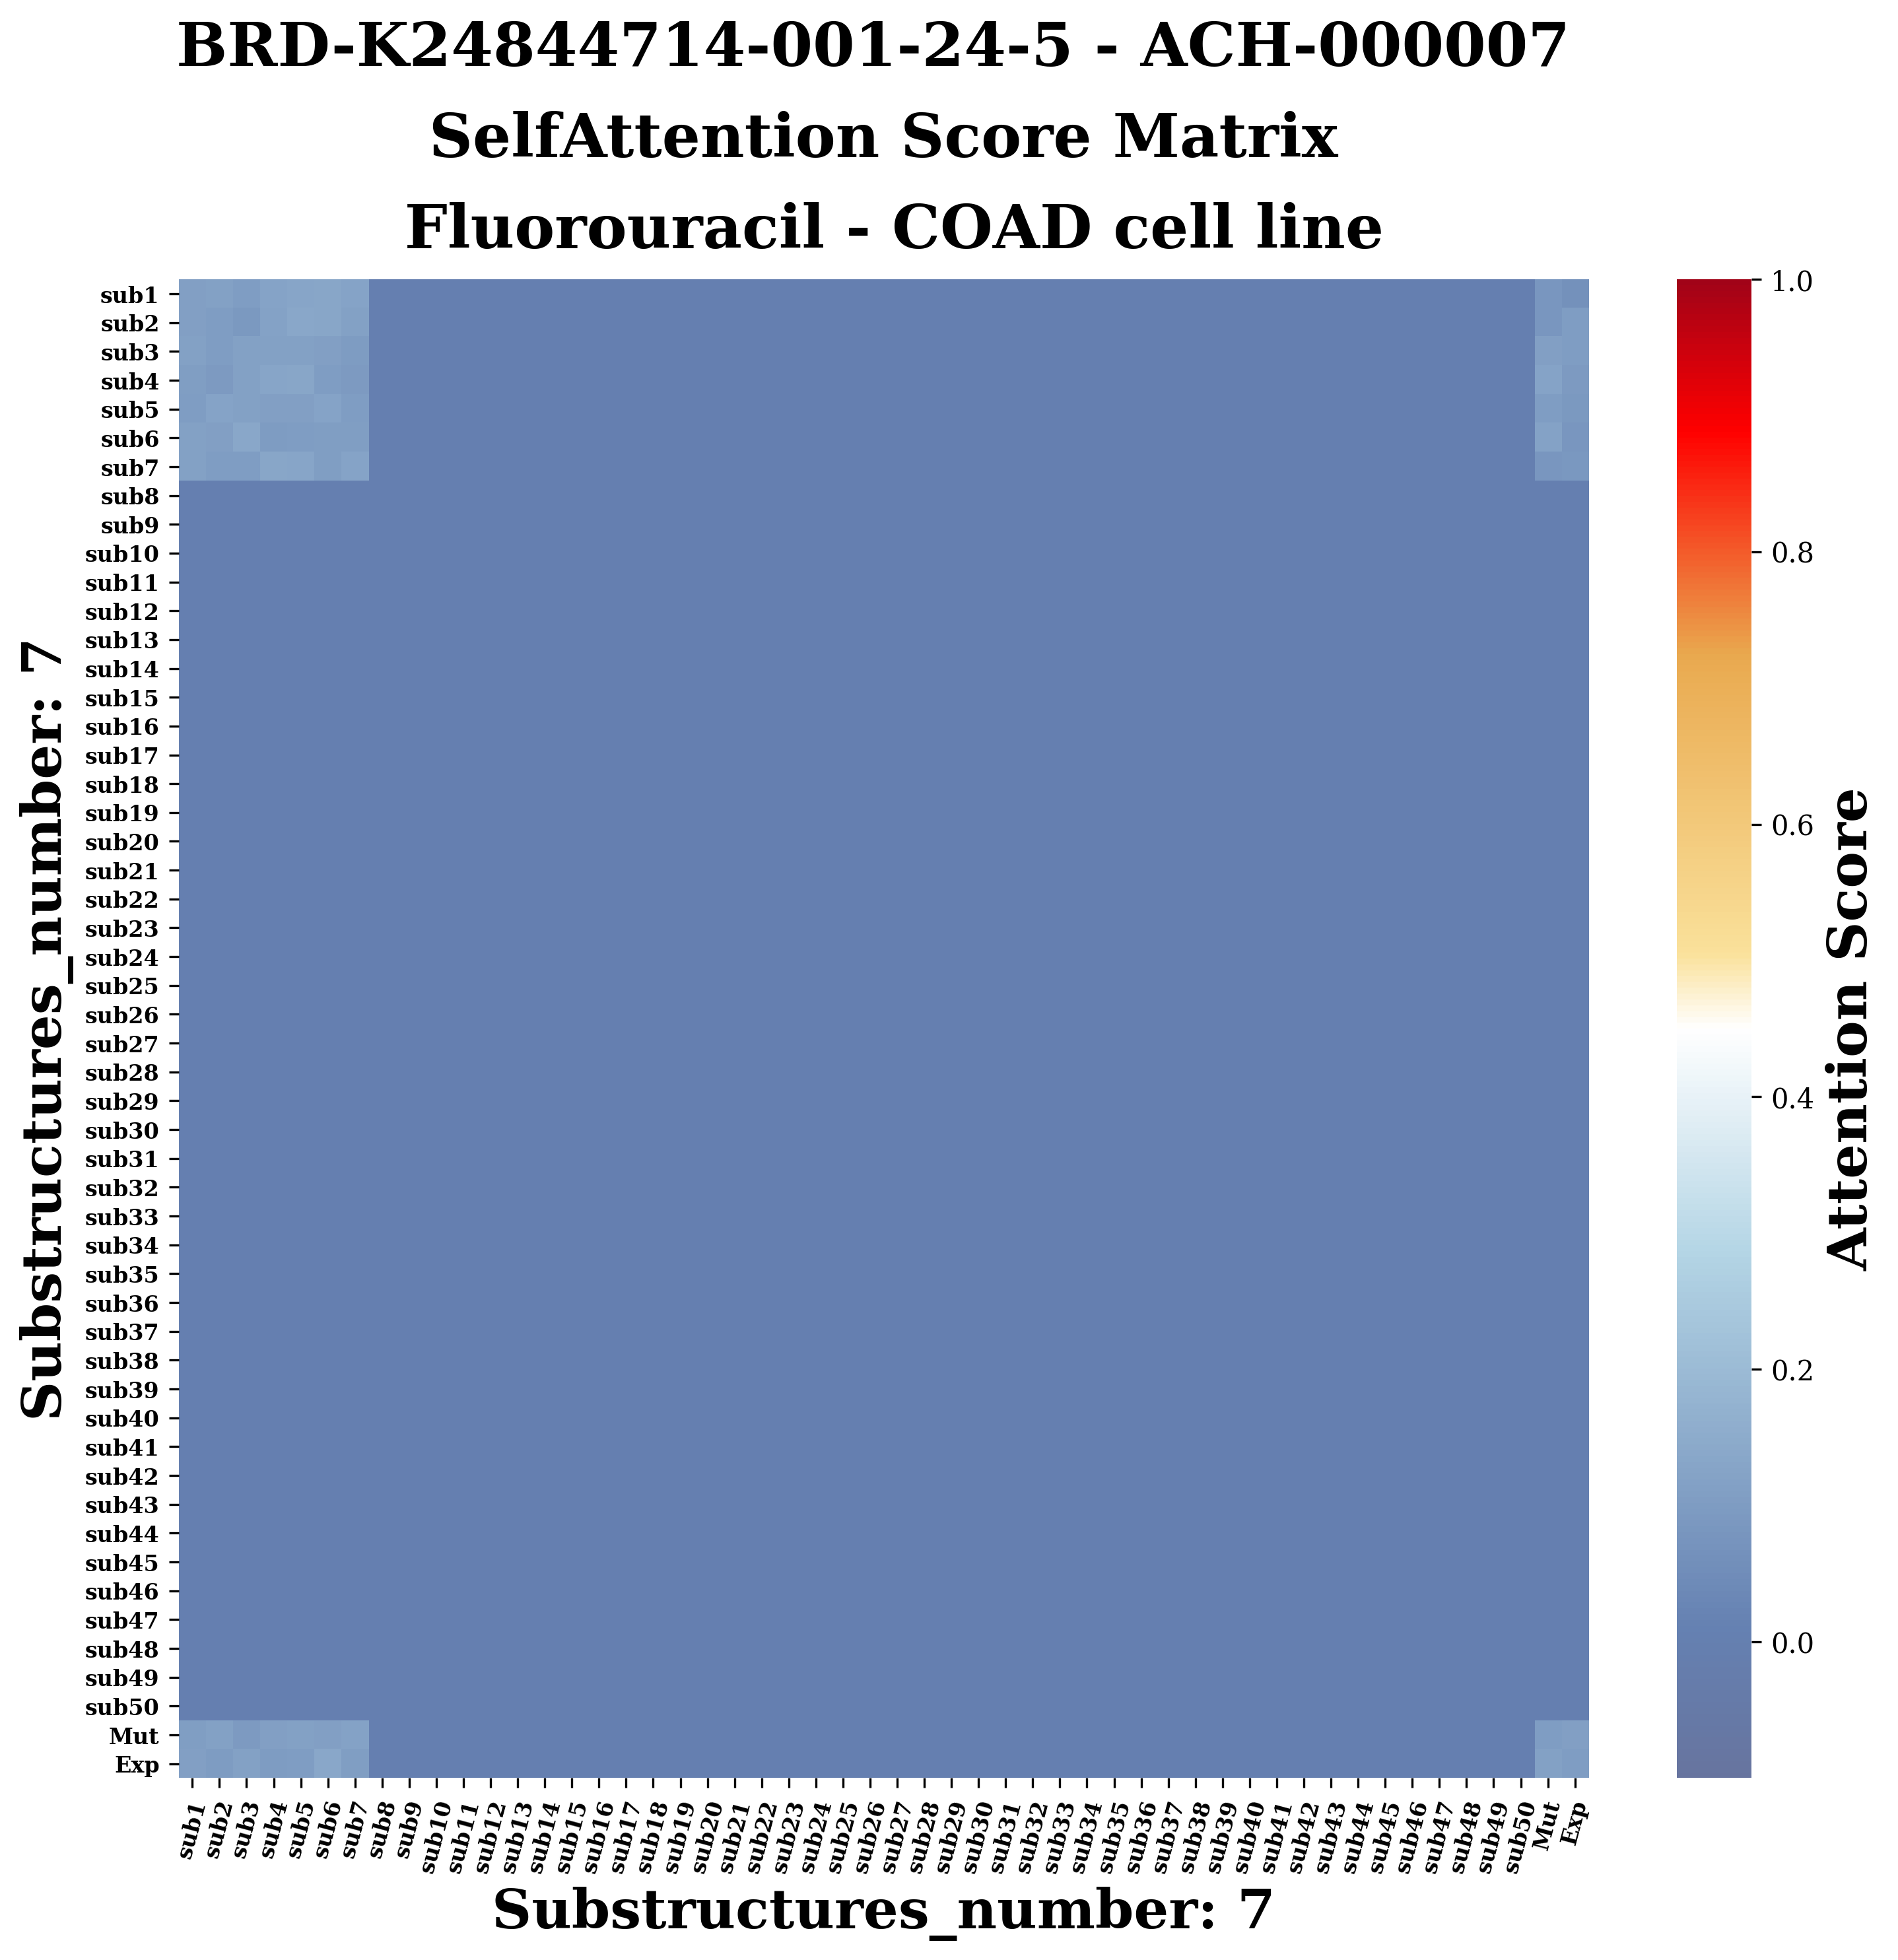

In [41]:
heatmap(AttenScorMat_DrugCellSelf.cpu(), drug_ID, cell_ID, drug_name_short, ccl_type, include_omics, fontsize_ticks=8 ,module="AttenScorMat_DrugCellSelf")

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


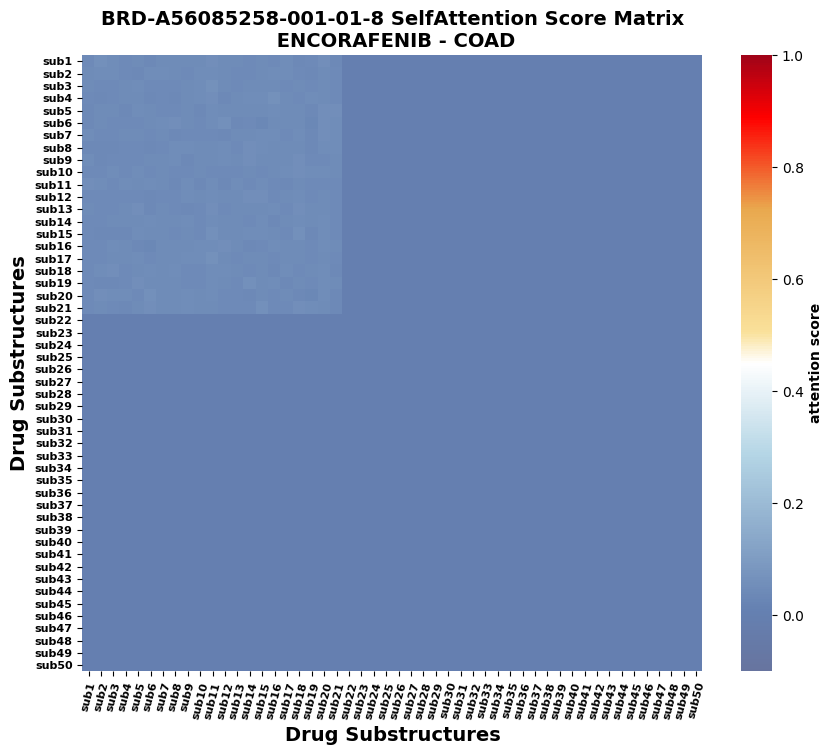

In [224]:
heatmap(AttenScorMat_DrugSelf.cpu(), drug_ID, cell_ID, drug_name_short, ccl_type, include_omics, fontsize_ticks=8 ,module="AttenScorMat_DrugSelf" )

In [42]:
print(drug_encode.values[0][2])
print(len(drug_encode.values[0][2]))

['F', 'c1c[nH]', 'c', '(=O)', '[nH]', 'c1', '=O']
7


tensor([[[ 49, 616,  26,  63, 118,  70, 180,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0],
         [  1,   1,   1,   1,   1,   1,   1,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0]]], device='cuda:0')
torch.Size([7, 7])


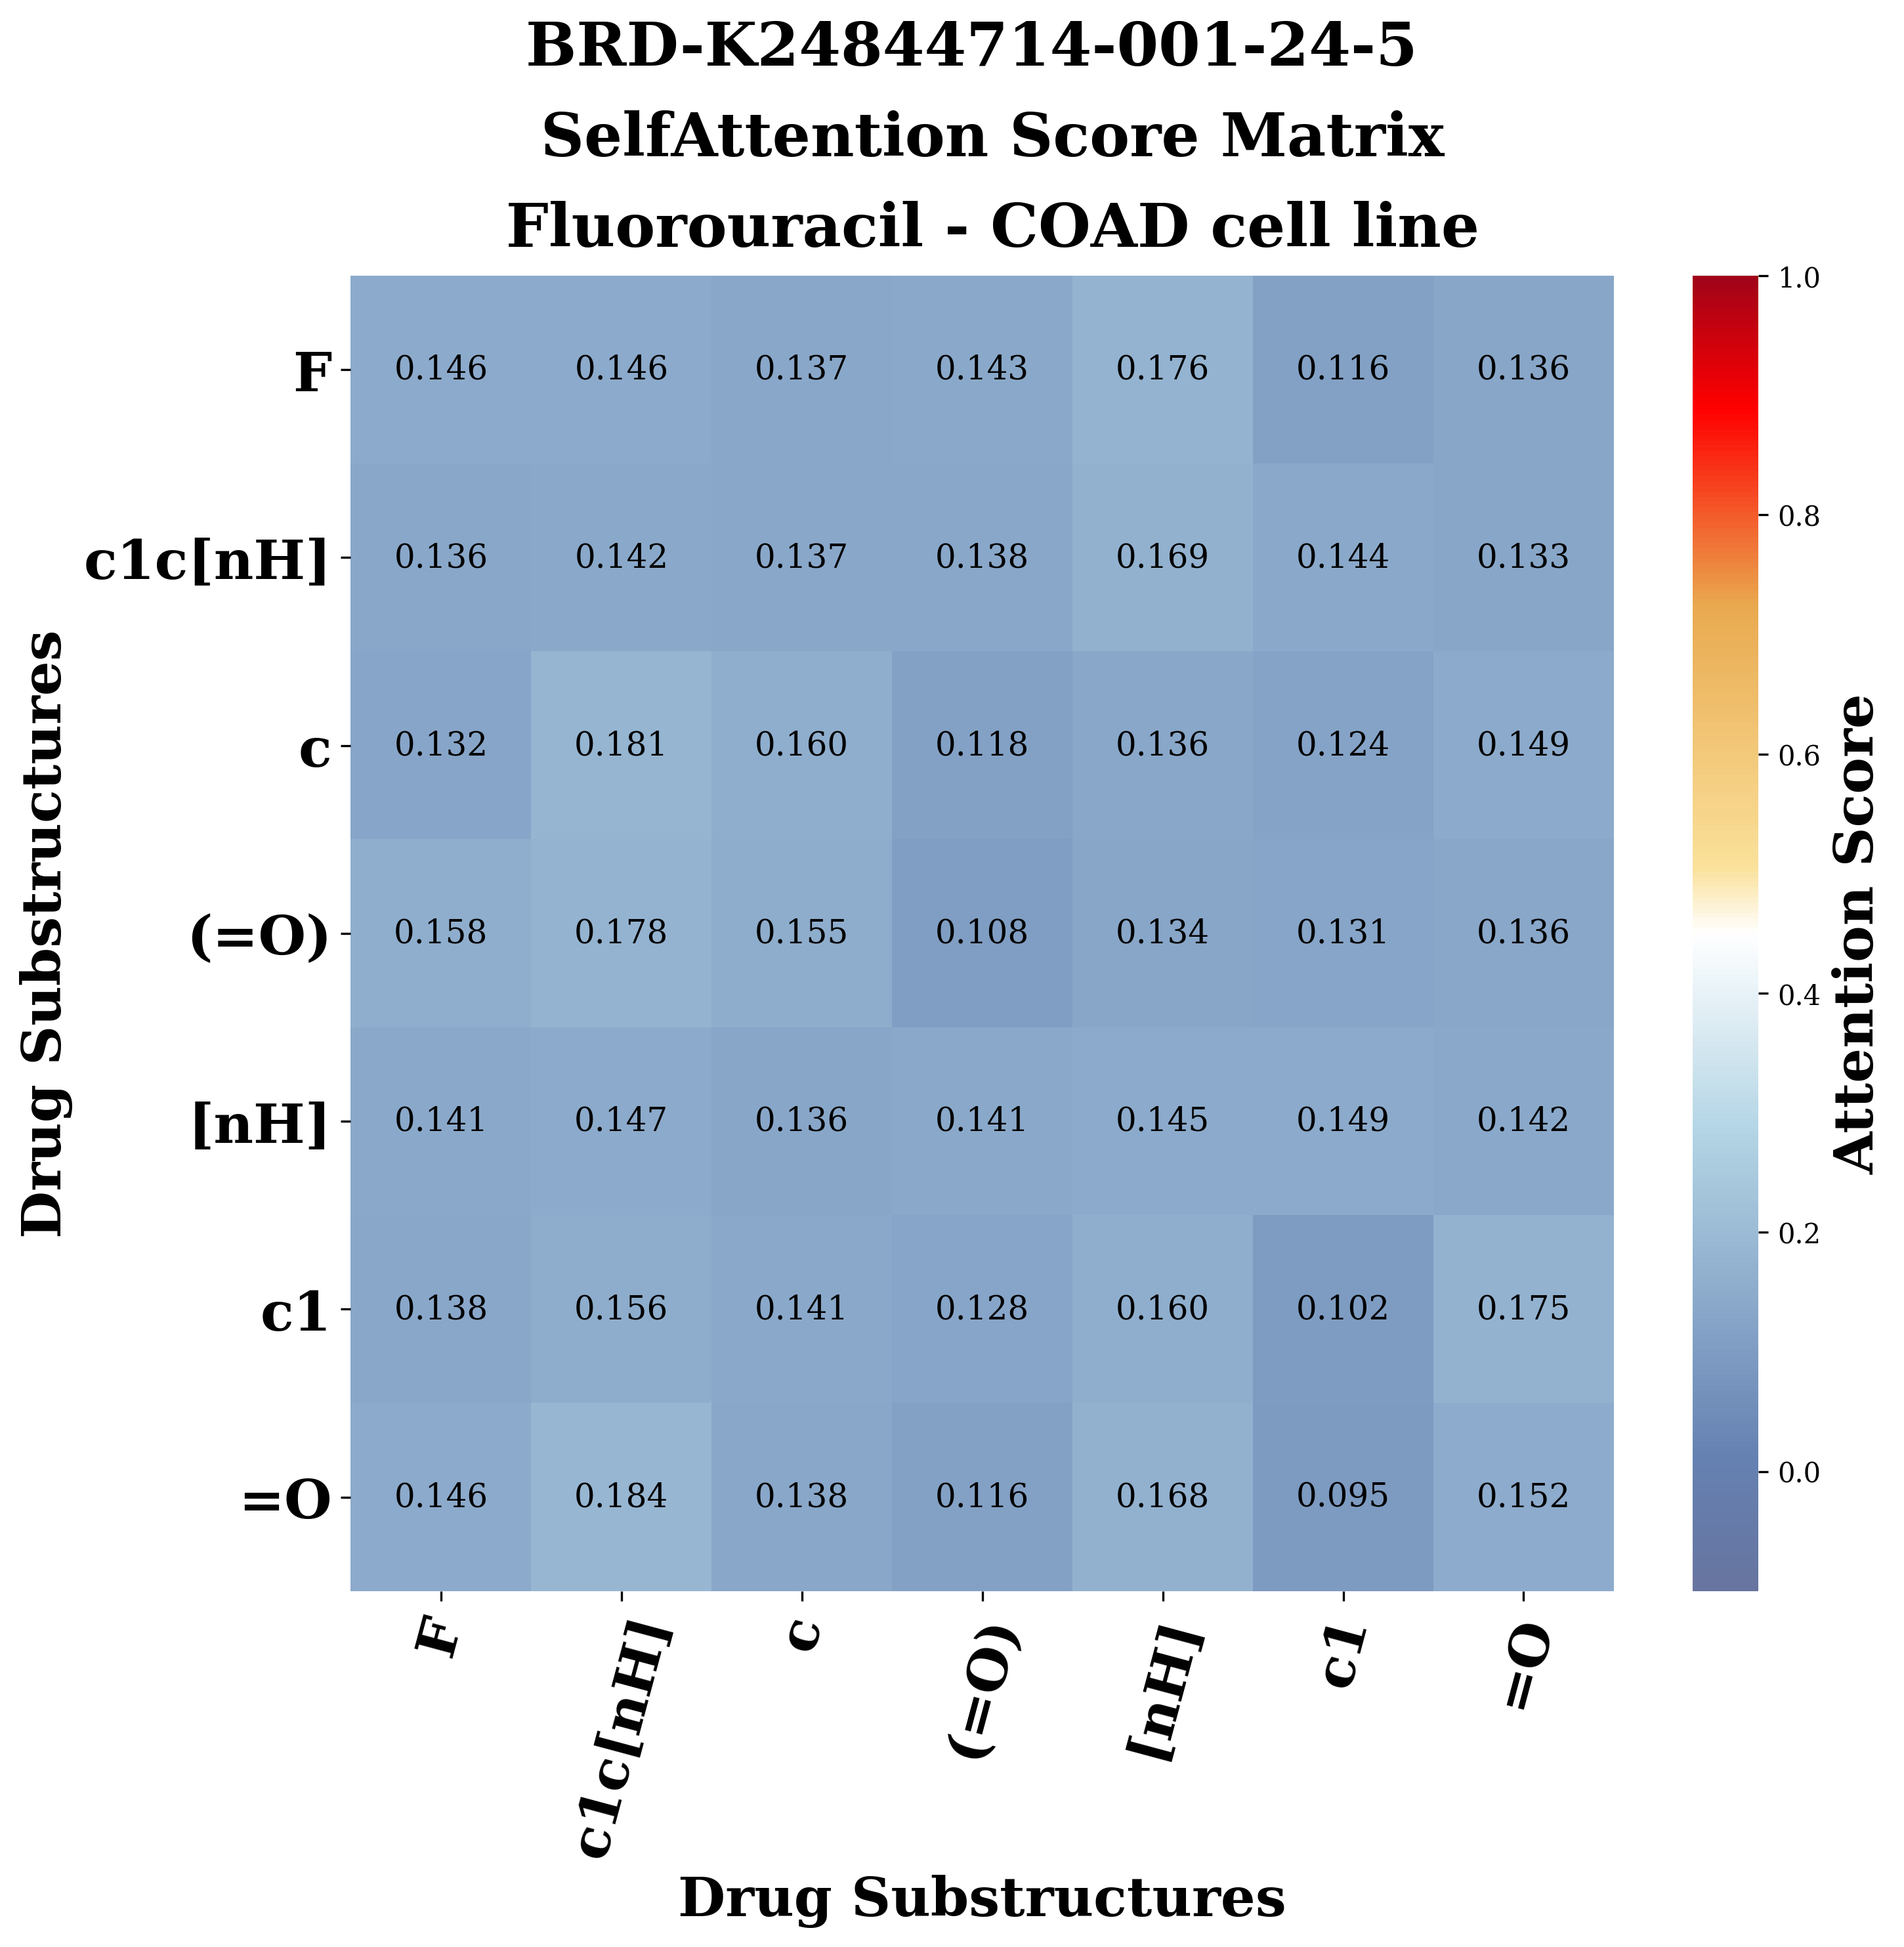

In [53]:
print(drug_features_tensor) # Fc1c[nH]c(=O)[nH]c1=O 
# Remove rows with all zeros
non_zero_rows = AttenScorMat_DrugSelf[~torch.all(AttenScorMat_DrugSelf == 0, dim=1)]
# Remove columns with all zeros
AttenScorMat_DrugSelf_dropnan = non_zero_rows[:, ~torch.all(non_zero_rows == 0, dim=0)]
print(AttenScorMat_DrugSelf_dropnan.shape)
heatmap(AttenScorMat_DrugSelf_dropnan.cpu(), drug_ID, cell_ID, drug_name_short, ccl_type, include_omics, fontsize_ticks=20, module="AttenScorMat_DrugSelf", sub= drug_encode.values[0][2])

In [44]:
top2 = torch.sort(AttenScorMat_DrugSelf_dropnan.flatten(), descending=True)[:2] # 找出matrix中最大的兩個分數 和indeces

print("top2 indices of flattened score matrix:", top2[1][:2].tolist(),"\n","score values:",top2[0][:2].tolist())
max_y, max_x = divmod(top2[1][0].item(), AttenScorMat_DrugSelf_dropnan.shape[1]) # divmod(index, num_cols) num_cols:矩阵的列数
print("max score matrix index pair:","sub",max_y+1,",", "sub",max_x+1)
print("max score matrix index pair y-axis:", drug_encode.values[0][2][max_y] )
print("max score matrix index pair x-axis:", drug_encode.values[0][2][max_x] )
# print(" max drug category index pair:",drug_features_tensor[0][0][max_y].item(),",",drug_features_tensor[0][0][max_x].item())

sec_max_y, sec_max_x = divmod(top2[1][1].item(), AttenScorMat_DrugSelf_dropnan.shape[1])
print("sec_max score matrix index pair:","sub",sec_max_y+1,",", "sub",sec_max_x+1)
print("sec_max score matrix index pair y-axis:", drug_encode.values[0][2][sec_max_y] )
print("sec_max score matrix index pair x-axis:", drug_encode.values[0][2][sec_max_x] )

# print(" sec_max drug category index pair:",drug_features_tensor[0][0][sec_max_y].item(),",",drug_features_tensor[0][0][sec_max_x].item())

top2 indices of flattened score matrix: [43, 15] 
 score values: [0.18428610265254974, 0.18130992352962494]
max score matrix index pair: sub 7 , sub 2
max score matrix index pair y-axis: =O
max score matrix index pair x-axis: c1c[nH]
sec_max score matrix index pair: sub 3 , sub 2
sec_max score matrix index pair y-axis: c
sec_max score matrix index pair x-axis: c1c[nH]


torch.Size([9, 9])


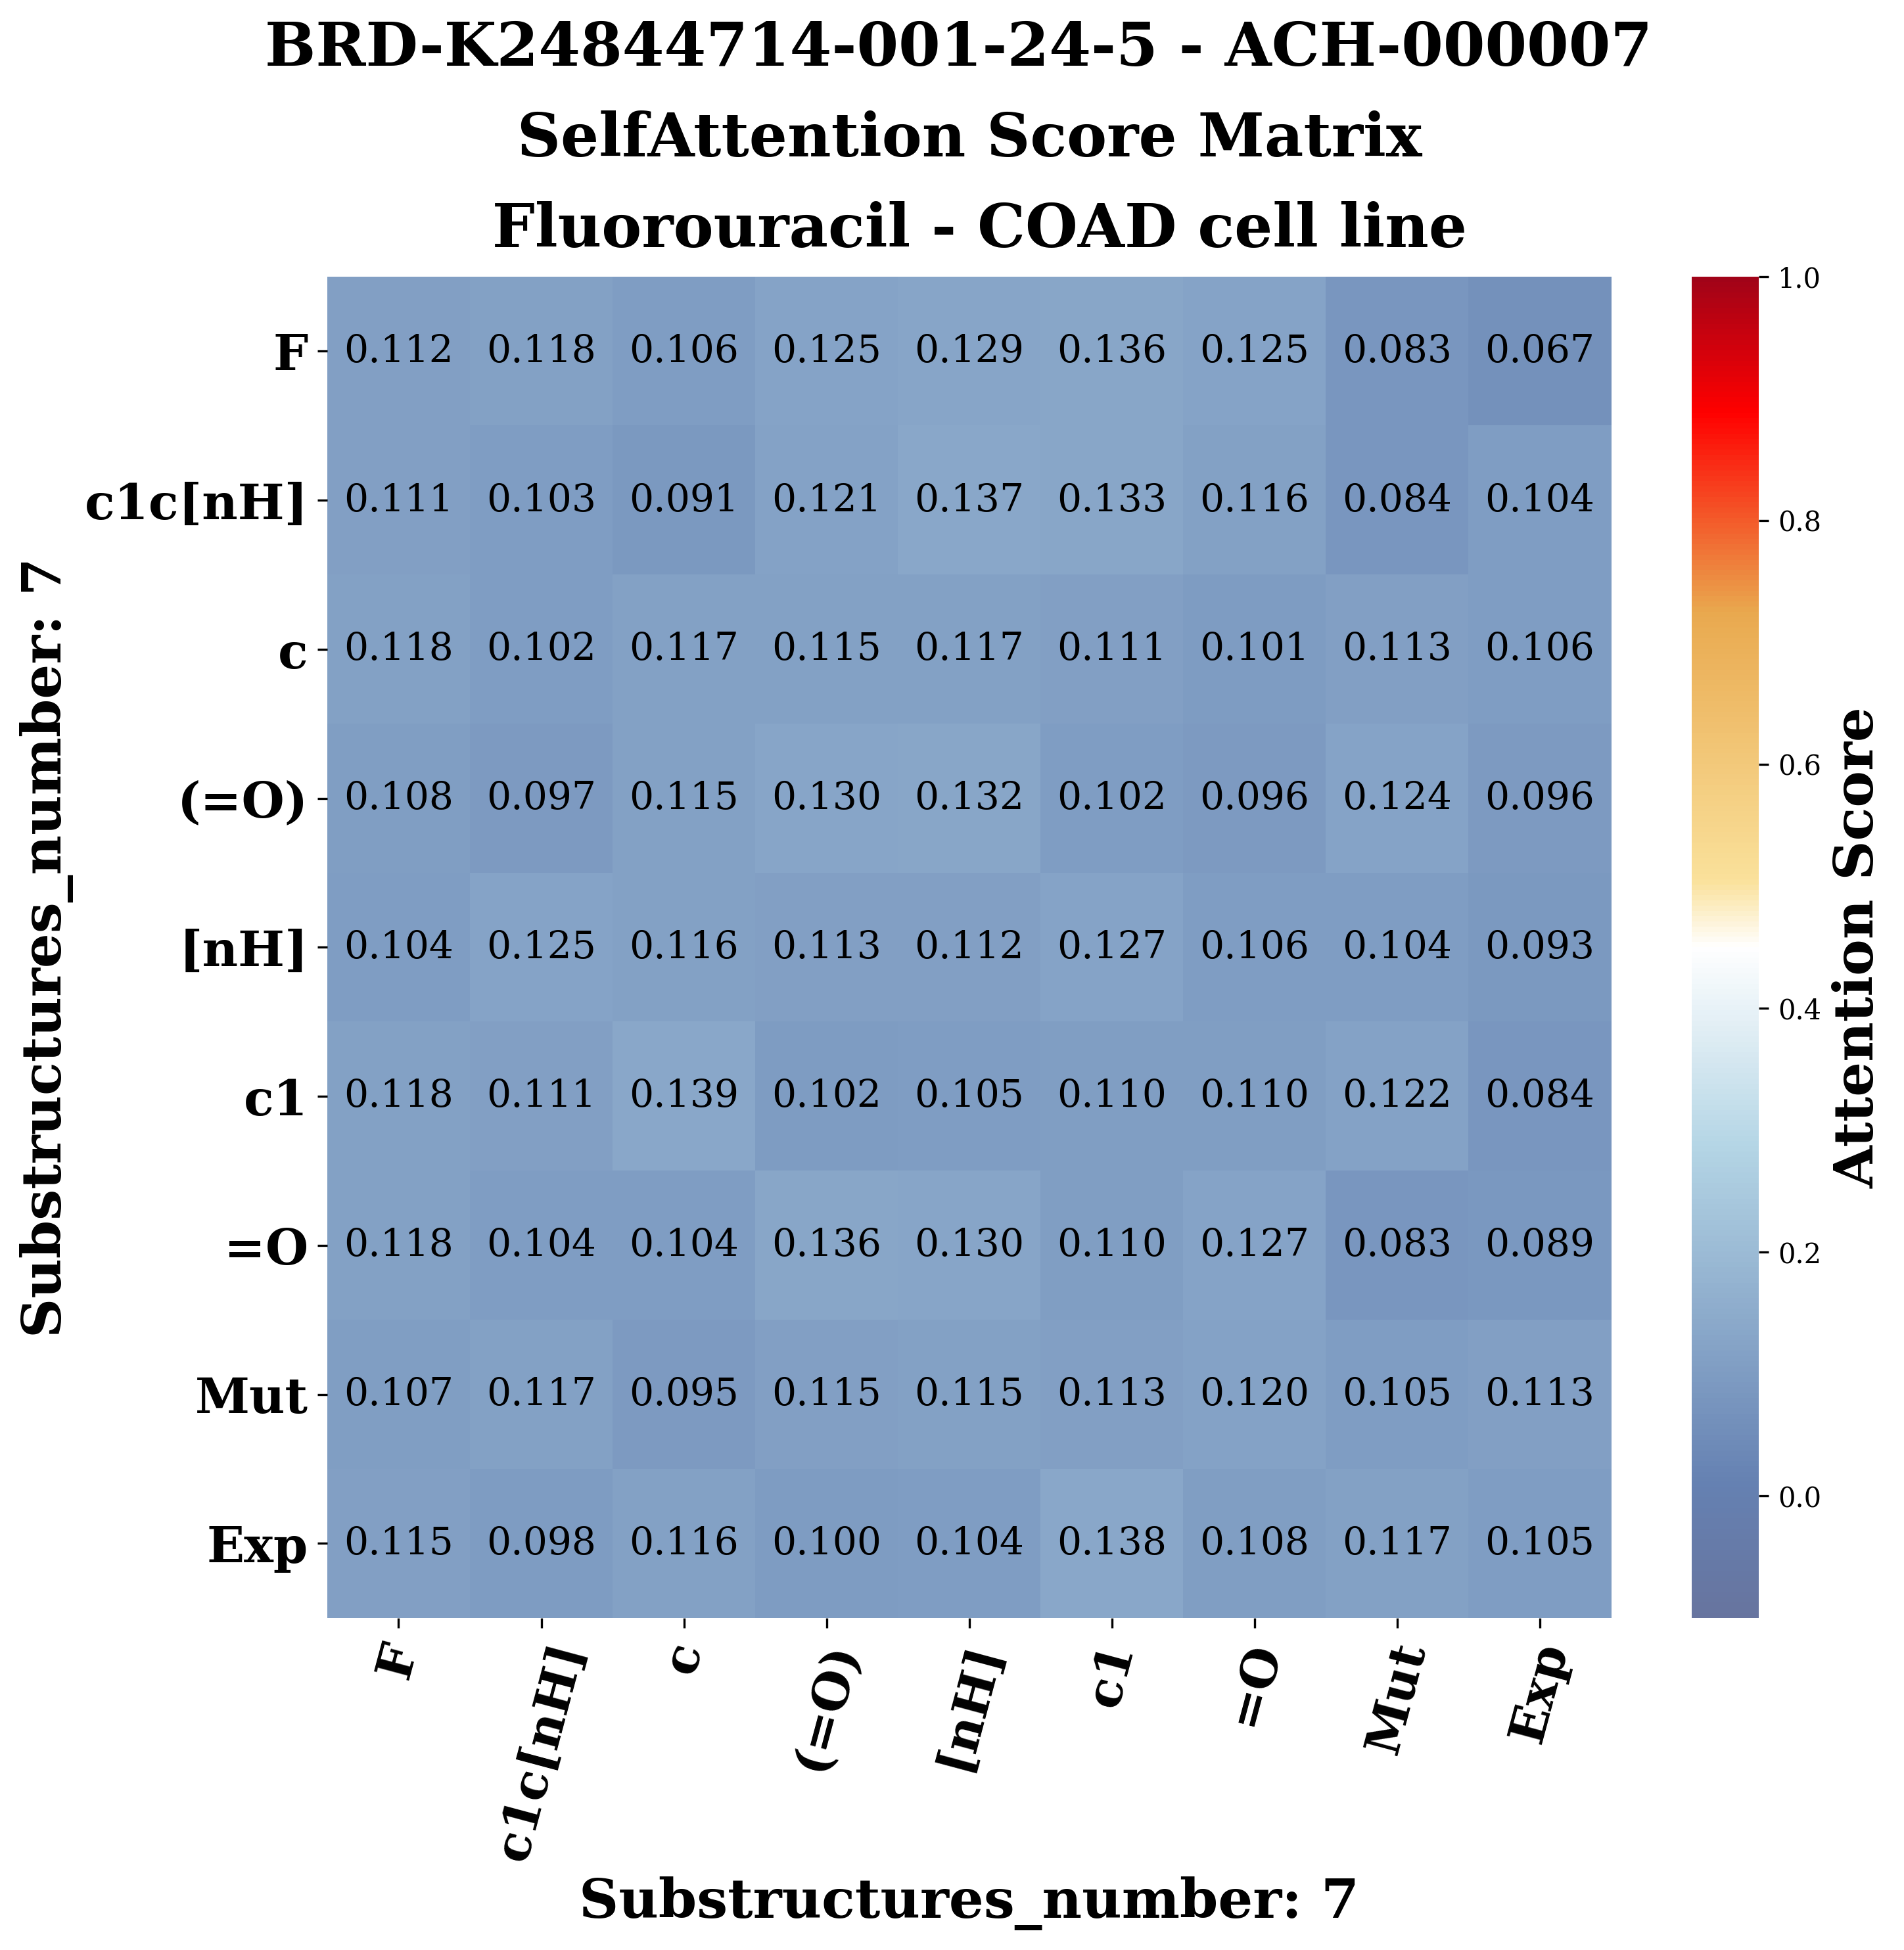

In [51]:
# Remove rows with all zeros
non_zero_rows = AttenScorMat_DrugCellSelf[~torch.all(AttenScorMat_DrugCellSelf == 0, dim=1)]
# Remove columns with all zeros
AttenScorMat_DrugCellSelf_dropnan = non_zero_rows[:, ~torch.all(non_zero_rows == 0, dim=0)]
print(AttenScorMat_DrugCellSelf_dropnan.shape)
heatmap(AttenScorMat_DrugCellSelf_dropnan.cpu(), drug_ID, cell_ID,drug_name_short,ccl_type, include_omics, fontsize_ticks=18, module="AttenScorMat_DrugCellSelf", sub= drug_encode.values[0][2])

In [46]:
top2 = torch.sort(AttenScorMat_DrugCellSelf_dropnan.flatten(), descending=True)[:2] # 找出matrix中最大的兩個分數 和indeces

print("top2 indices of flattened score matrix:", top2[1][:2].tolist(),"\n","score values:",top2[0][:2].tolist())
max_y, max_x = divmod(top2[1][0].item(), AttenScorMat_DrugCellSelf_dropnan.shape[1]) # divmod(index, num_cols) num_cols:矩阵的列数
print("max score matrix index pair:","sub",max_y+1,",","sub", max_x+1)
if max_y+1 > len(drug_encode.values[0][2]) and max_x+1 > len(drug_encode.values[0][2]):
    print("max score matrix index pair y-axis:", include_omics[ max_y - len(drug_encode.values[0][2]) ] )
    print("max score matrix index pair x-axis:", include_omics[ max_x - len(drug_encode.values[0][2]) ] )
elif max_y+1 > len(drug_encode.values[0][2]):
    print("max score matrix index pair y-axis:", include_omics[ max_y - len(drug_encode.values[0][2]) ] )
    print("max score matrix index pair x-axis:", drug_encode.values[0][2][max_x] )
elif max_x+1 > len(drug_encode.values[0][2]):   
    print("max score matrix index pair y-axis:", drug_encode.values[0][2][max_y] )
    print("max score matrix index pair x-axis:", include_omics[ max_x - len(drug_encode.values[0][2]) ] )
else:
    print("max score matrix index pair y-axis:", drug_encode.values[0][2][max_y] )
    print("max score matrix index pair x-axis:", drug_encode.values[0][2][max_x] )
# print(" max drug category index pair:",drug_features_tensor[0][0][max_y].item(),",",drug_features_tensor[0][0][max_x].item())

sec_max_y, sec_max_x = divmod(top2[1][1].item(), AttenScorMat_DrugCellSelf_dropnan.shape[1])
print("sec_max score matrix index pair:","sub",sec_max_y+1,",", "sub",sec_max_x+1)

if  sec_max_y+1 > len(drug_encode.values[0][2]) and sec_max_x+1 > len(drug_encode.values[0][2]):
    print("sec_max score matrix index pair y-axis:", include_omics[ sec_max_y - len(drug_encode.values[0][2]) ] )
    print("sec_max score matrix index pair x-axis:", include_omics[ sec_max_x - len(drug_encode.values[0][2]) ] )
elif sec_max_y+1 > len(drug_encode.values[0][2]):
    print("sec_max score matrix index pair y-axis:", include_omics[ sec_max_y - len(drug_encode.values[0][2]) ] )
    print("sec_max score matrix index pair x-axis:", drug_encode.values[0][2][sec_max_x] )
elif sec_max_x+1 > len(drug_encode.values[0][2]):   
    print("sec_max score matrix index pair y-axis:", drug_encode.values[0][2][sec_max_y] )
    print("sec_max score matrix index pair x-axis:", include_omics[ sec_max_x - len(drug_encode.values[0][2]) ] )
else:
    print("sec_max score matrix index pair y-axis:", drug_encode.values[0][2][sec_max_y] )
    print("sec_max score matrix index pair x-axis:", drug_encode.values[0][2][sec_max_y] )
# print(" sec_max drug category index pair:",drug_features_tensor[0][0][sec_max_y].item(),",",drug_features_tensor[0][0][sec_max_x].item())

top2 indices of flattened score matrix: [47, 77] 
 score values: [0.13927212357521057, 0.1375821828842163]
max score matrix index pair: sub 6 , sub 3
max score matrix index pair y-axis: c1
max score matrix index pair x-axis: c
sec_max score matrix index pair: sub 9 , sub 6
sec_max score matrix index pair y-axis: Exp
sec_max score matrix index pair x-axis: c1
